# Generative Models

## GANs & VAE

### HW4

**Full Name:** Seyed Amir Kasaei

**SID:** 402212214

contribution with amir mohammad ezzati

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [1]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/AI/Deep Learning/DL/HW4/'

Mounted at /content/drive


# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [3]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [4]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 18163383.00it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 494732.28it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4408586.93it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4987049.42it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
num_threads = 2 # TODO
batch_size = 64 # TODO

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads) # TODO

val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_threads) # TODO

# Helper function

In [6]:
def plot_random_smaple(model, latent_dim, n=4):
  z = torch.randn(n, latent_dim).to(DEVICE)
  samples = model(z).cpu()
  samples = samples.view(n, 1, 28, 28)

  fig, axes = plt.subplots(n//4, 4, figsize=(8, n//2))
  idx=0
  for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[idx].squeeze().cpu().detach().numpy(), cmap='gray')
    ax.axis("off")
    idx += 1

  plt.tight_layout()
  plt.show()

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        ##########################################################
        # TODO
        # Define your variational encoder layers.
        ##########################################################
        self.input_dim = input_dim

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.relu = nn.ReLU()


    def forward(self, x):

        ##########################################################
        # TODO
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        ##########################################################
        x = x.view(-1, self.input_dim)

        H = self.relu(self.fc1(x))
        H = self.relu(self.fc2(H))

        z_mean = self.fc_mean(H)

        logvar = self.fc_logvar(H)
        z_log_var = torch.exp(0.5 * logvar)

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        ##############################
        # TODO
        # Define your decoder layers.
        ##############################
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, z):
        ########################################
        # TODO
        # Decode the latent vector `z` to images.
        ########################################
        H = self.relu(self.fc1(z))
        H = self.relu(self.fc2(H))
        x = self.sigmoid(self.fc3(H))

        return x

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        ##########################################################
        # TODO
        # Using the encoder and decoder you have defined, encode the
        # image to the latent space and then reconstruct it.
        # Use the eeparameterization trick to ensure gradient flow.
        ##########################################################
        z_mean, z_log_var = self.encoder(x)

        epsilon = torch.randn_like(z_log_var).to(DEVICE)        # sampling epsilon
        z = z_mean + z_log_var * epsilon                        # reparameterization trick

        image = self.decoder(z).view(-1, 1, 28, 28)

        return image, z_mean, z_log_var

In [9]:
def reconstruct_images(vae, images):
    vae.eval()
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images

In [10]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [11]:
def train_vae(dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-3, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizer and VAE model.
    ###############################################
    model =  VAE(input_dim, hidden_dim, latent_dim).to(DEVICE) # TODO
    criterion = loss_function # TODO
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # TODO
    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    recon_images = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:

                ###############################################
                # TODO
                # Calculate the loss.
                # (optional) Use the KL divergence loss to normalize the
                # output distribution of decoder.
                ###############################################
                x, _ = data
                x = x.to(DEVICE)

                optimizer.zero_grad()

                x_hat, mu, log_var = model(x)
                loss = criterion(x, x_hat, mu, log_var)

                train_loss += loss.item()

                loss.backward()
                optimizer.step()

            print(f'Epoch {epoch+1} -', 'Loss: {:.4f}'.format(train_loss / len(dataloader.dataset)))

        # TODO
        # Reconstruct `sample_images` and plot first 4 images after each epoch
        # This is used to visualize the progress
        recon_images = reconstruct_images(model, sample_images)
        fig, axes = plt.subplots(2, 4, figsize=(8, 4))
        for i in range(4):
            axes[0, i].imshow(sample_images[i].squeeze().cpu().numpy(), cmap='gray')
            axes[0, i].set_title('Sample')
            axes[0, i].axis('off')

            axes[1, i].imshow(recon_images[i].squeeze().cpu().numpy(), cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        plt.show()

    return model

In [12]:
def eval_vae(model, dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-3):
    ###############################################
    # TODO
    # Define the loss fc, optimizer and VAE model.
    ###############################################
    model.eval()
    criterion = loss_function # TODO
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # TODO

    val_loss = 0.0
    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, data in pbar:
            x, _ = data
            x = x.to(DEVICE)

            optimizer.zero_grad()

            x_hat, mu, log_var = model(x)
            loss = criterion(x, x_hat, mu, log_var)

            val_loss += loss.item()

        print('Validation -', 'Loss: {:.4f}'.format(val_loss / len(dataloader.dataset)))

    return

In [ ]:
input_dim = 784
hidden_dim = 256
latent_dim = 10

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 - Loss: 154.5018


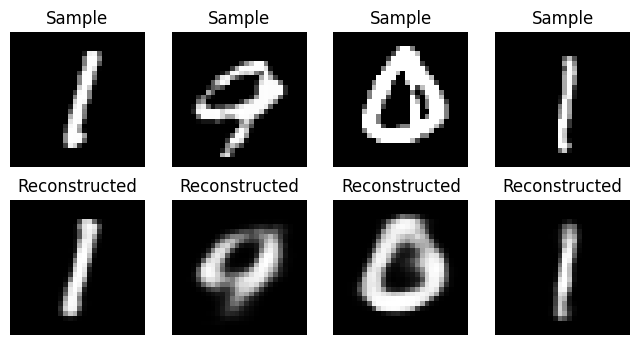

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 - Loss: 104.5067


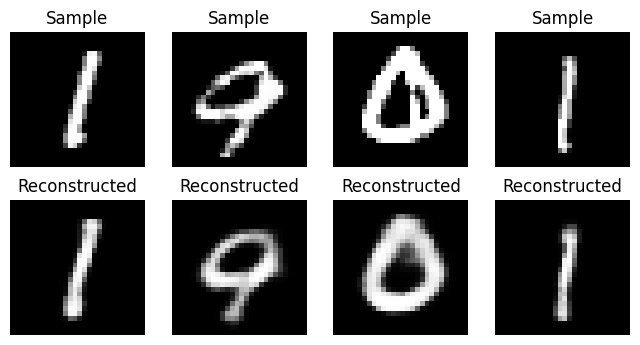

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3 - Loss: 96.2331


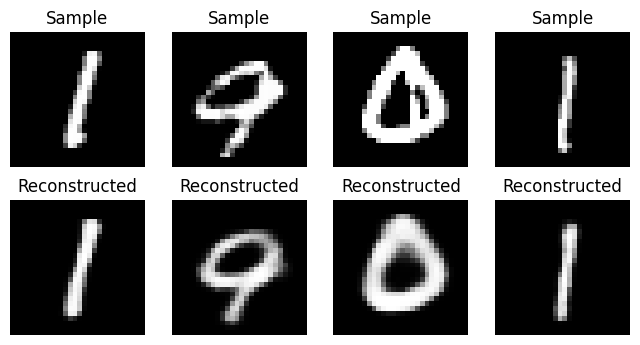

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4 - Loss: 92.2511


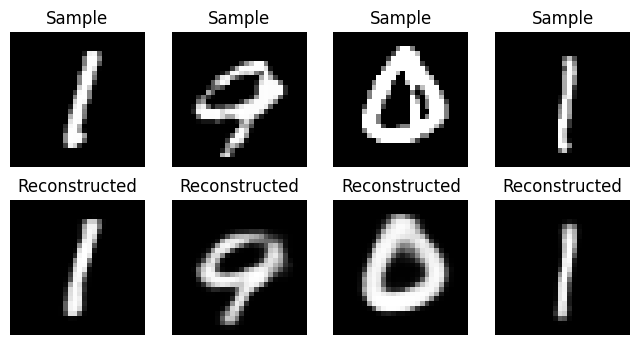

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5 - Loss: 89.7231


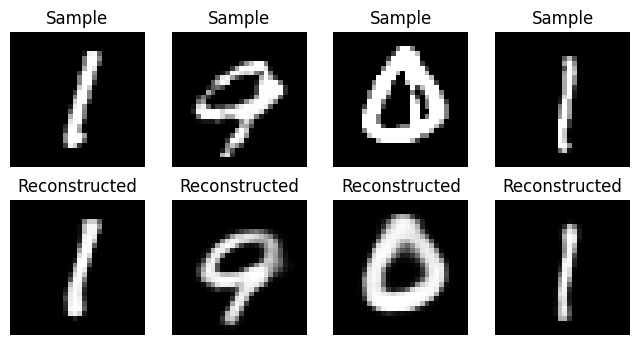

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6 - Loss: 87.9404


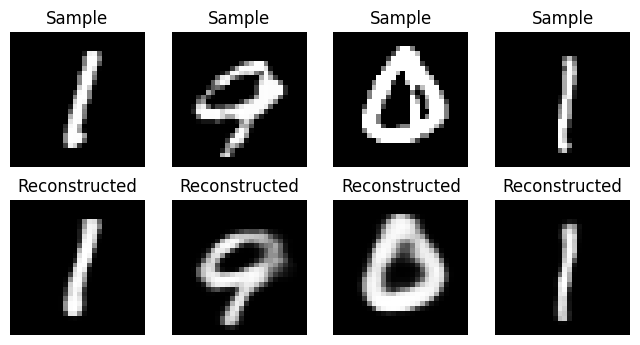

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7 - Loss: 86.5481


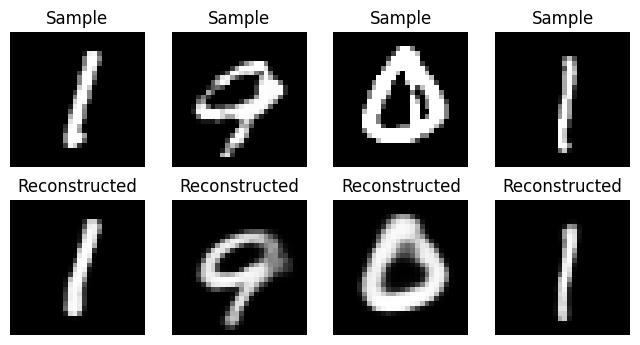

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8 - Loss: 85.4656


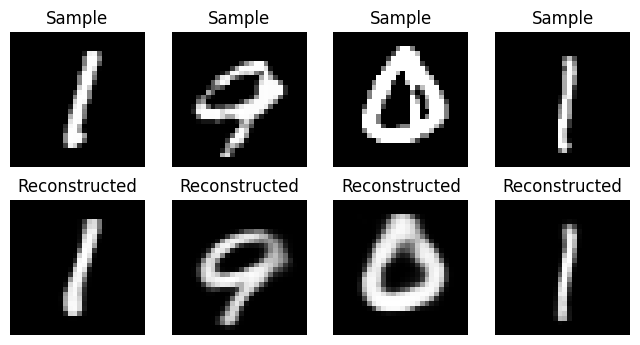

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9 - Loss: 84.5543


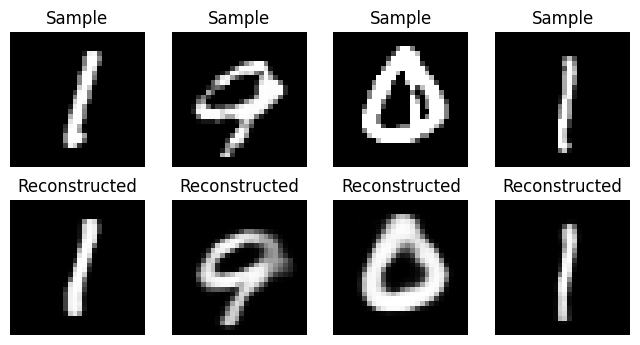

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10 - Loss: 83.8076


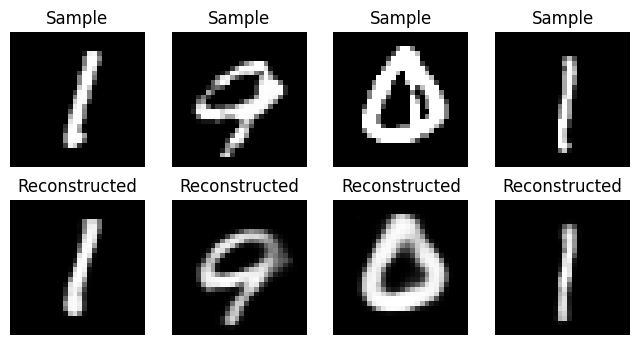

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 11 - Loss: 83.0782


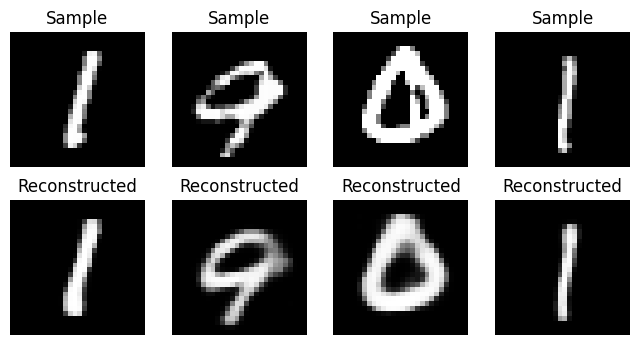

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 12 - Loss: 82.5338


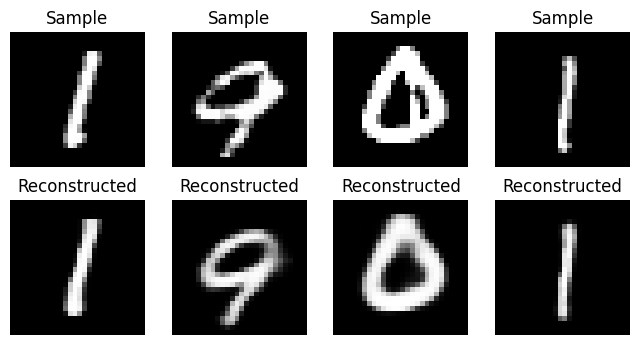

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 13 - Loss: 82.0507


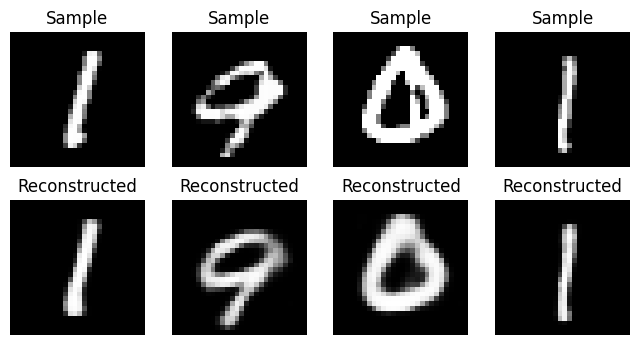

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 14 - Loss: 81.6033


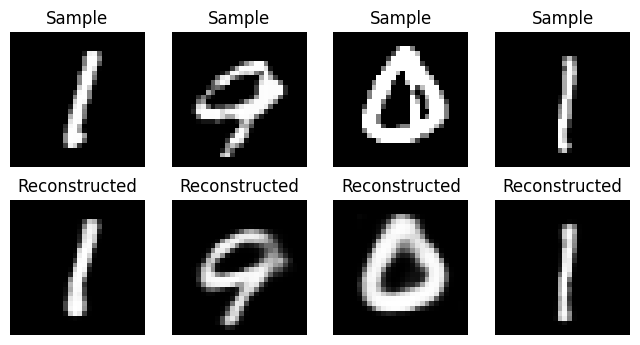

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 15 - Loss: 81.1747


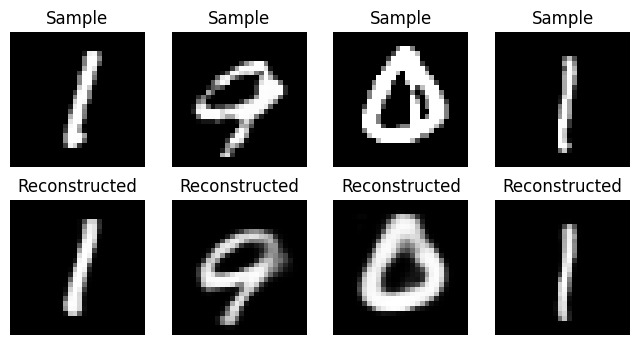

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 16 - Loss: 80.8677


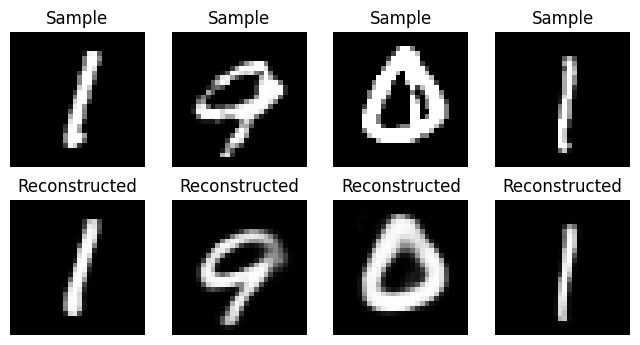

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 17 - Loss: 80.5032


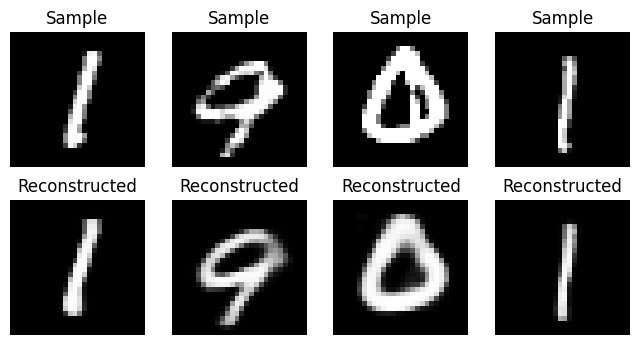

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 18 - Loss: 80.2363


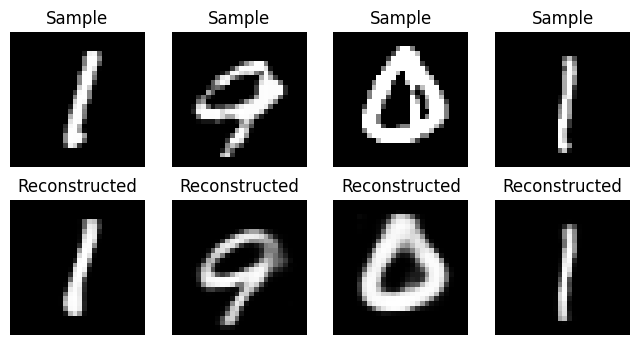

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 19 - Loss: 79.8928


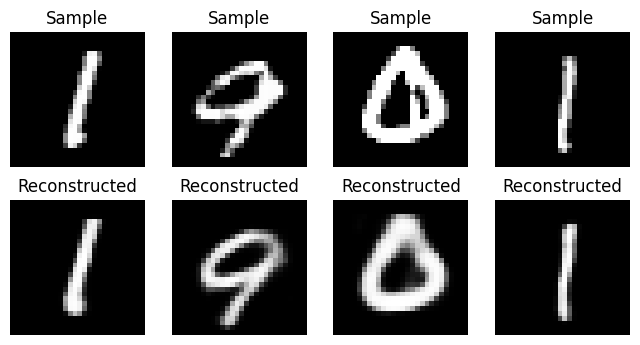

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 20 - Loss: 79.6966


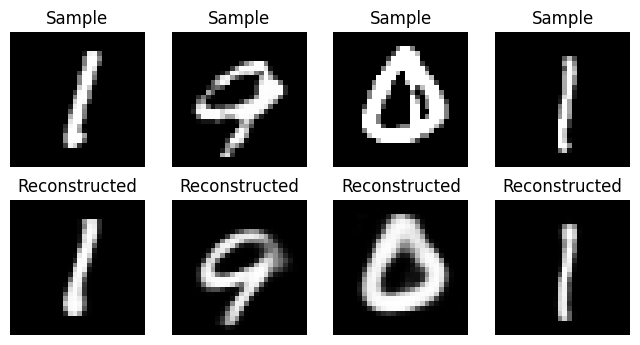

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 21 - Loss: 79.4464


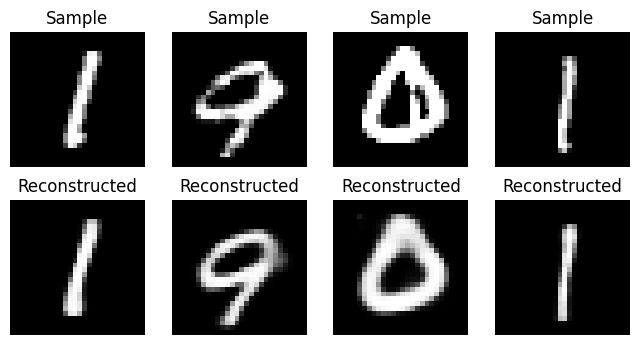

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 22 - Loss: 79.2170


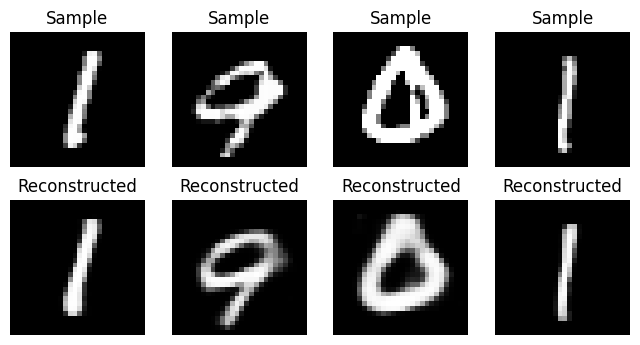

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 23 - Loss: 78.9992


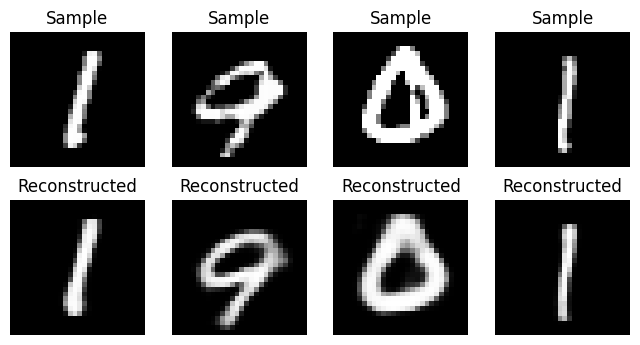

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 24 - Loss: 78.8628


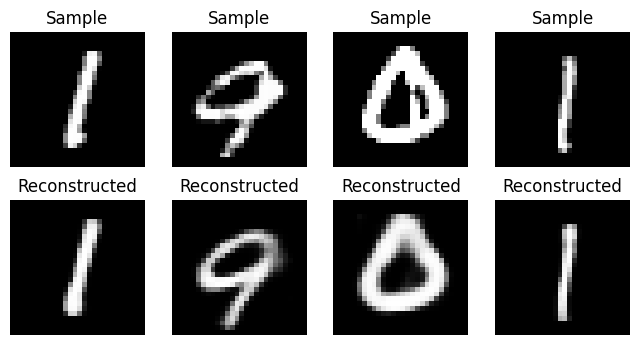

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 25 - Loss: 78.6297


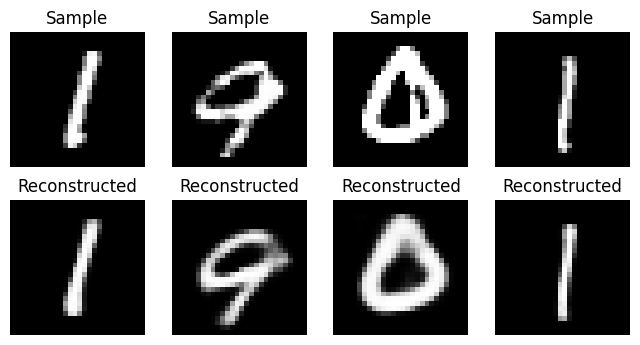

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 26 - Loss: 78.4556


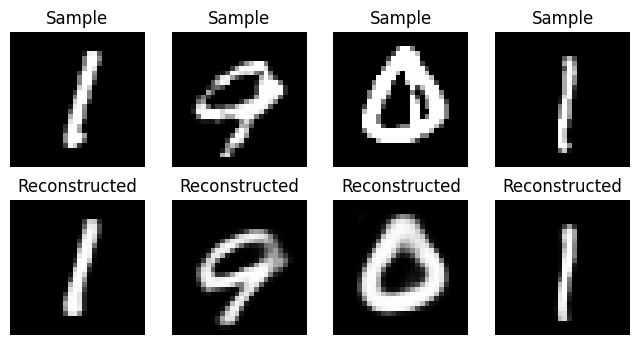

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 27 - Loss: 78.2764


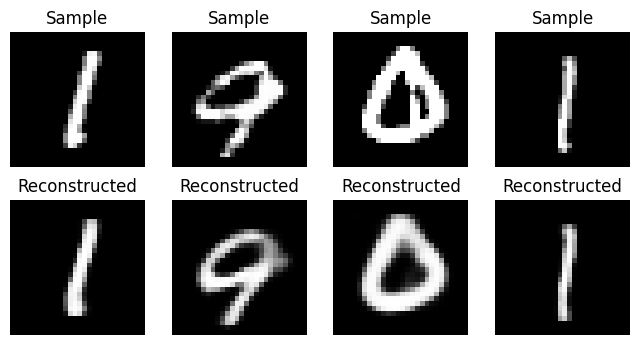

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 28 - Loss: 78.2011


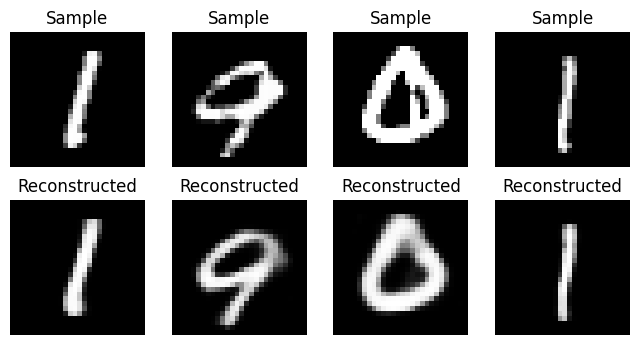

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 29 - Loss: 78.0019


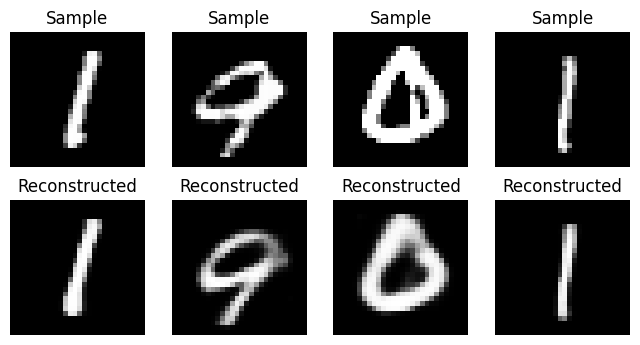

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 30 - Loss: 77.9018


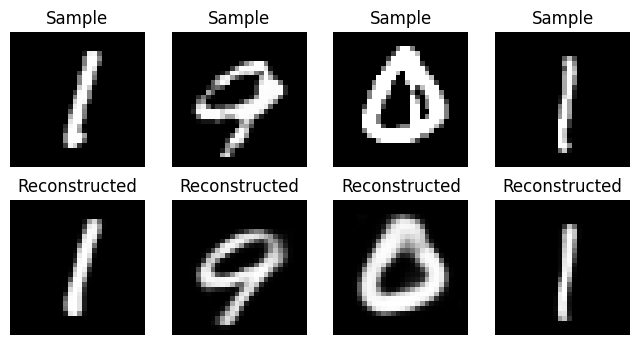

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 31 - Loss: 77.7556


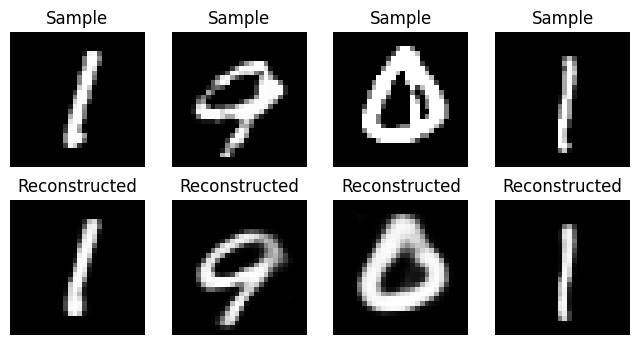

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 32 - Loss: 77.6083


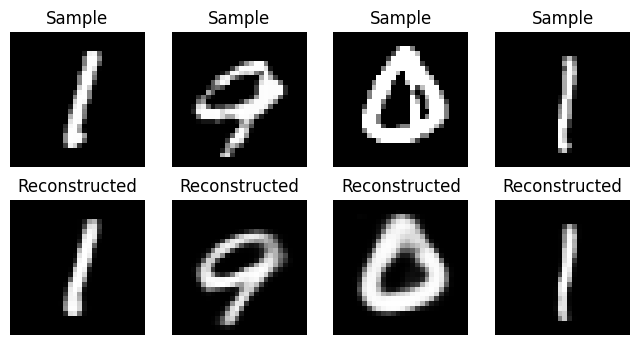

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 33 - Loss: 77.4847


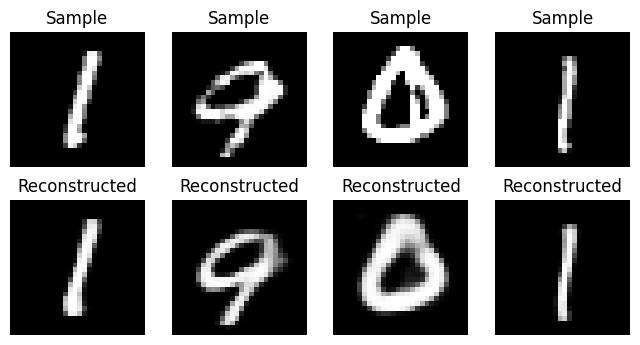

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 34 - Loss: 77.3837


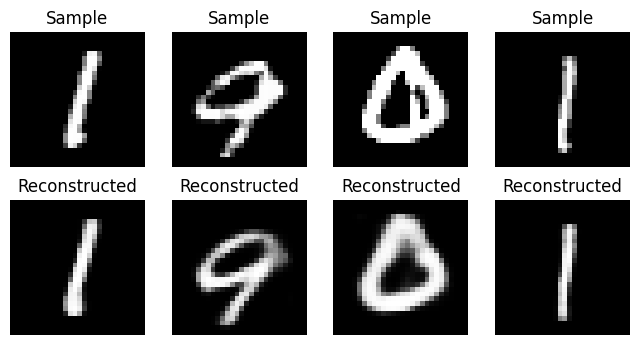

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 35 - Loss: 77.3016


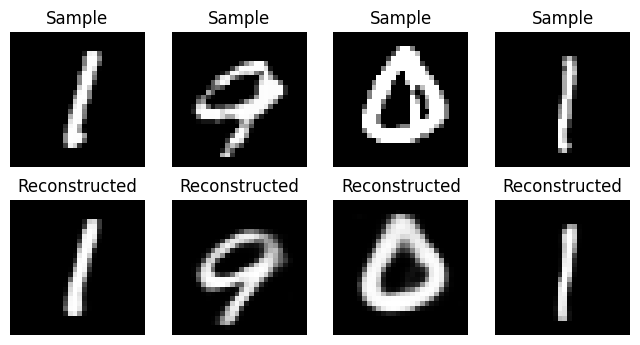

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 36 - Loss: 77.1916


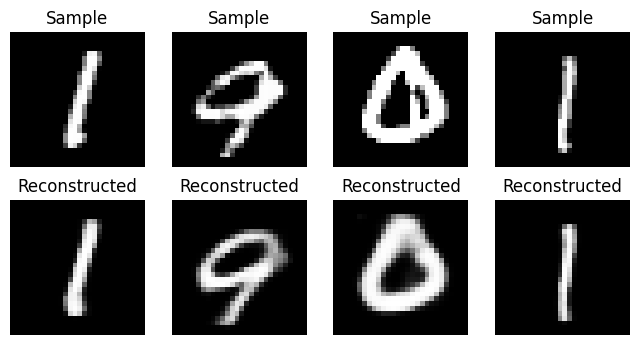

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 37 - Loss: 77.0703


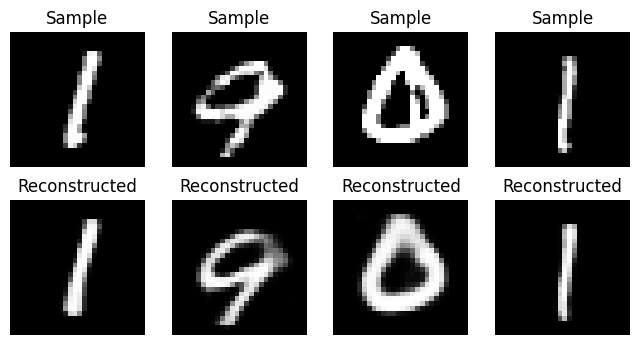

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 38 - Loss: 76.9953


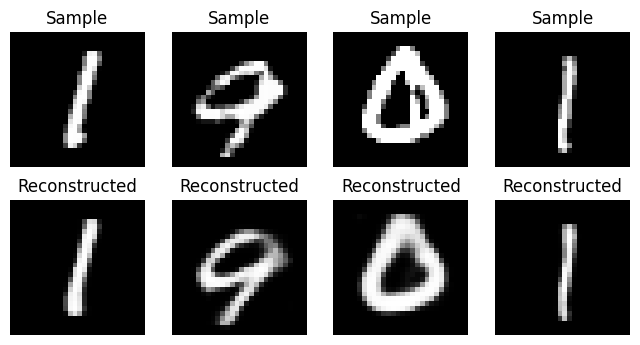

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 39 - Loss: 76.9130


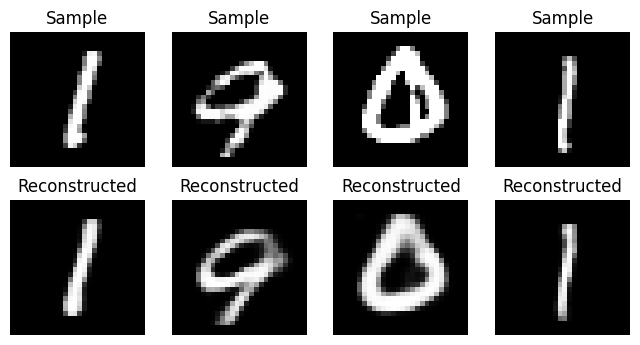

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 40 - Loss: 76.8369


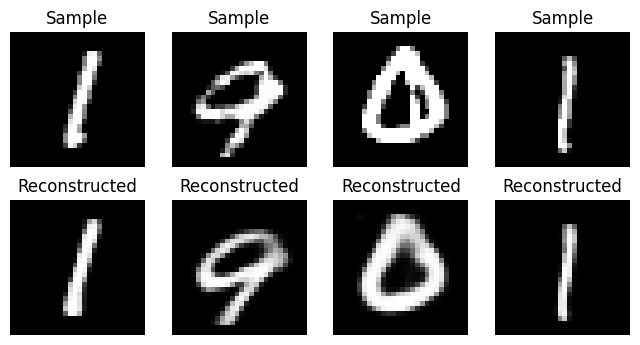

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 41 - Loss: 76.7188


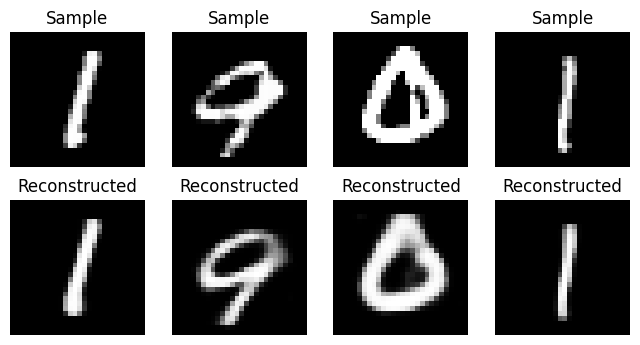

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 42 - Loss: 76.6525


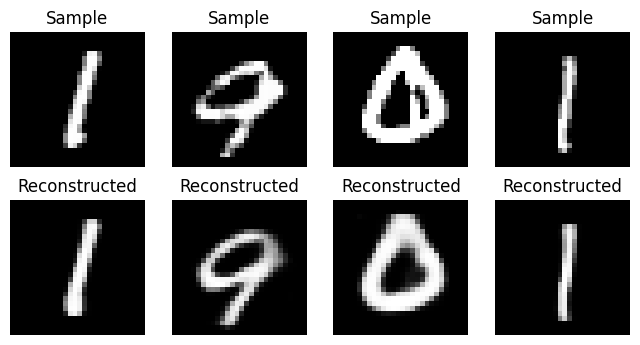

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 43 - Loss: 76.6121


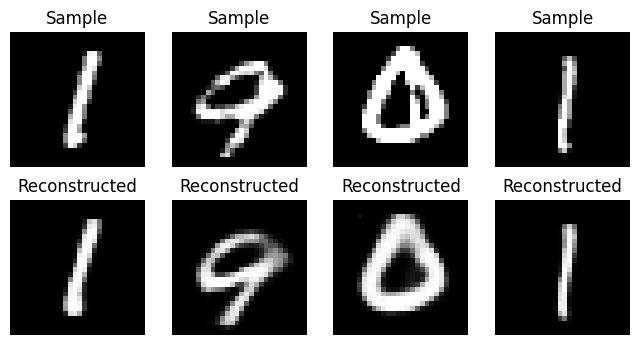

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 44 - Loss: 76.4918


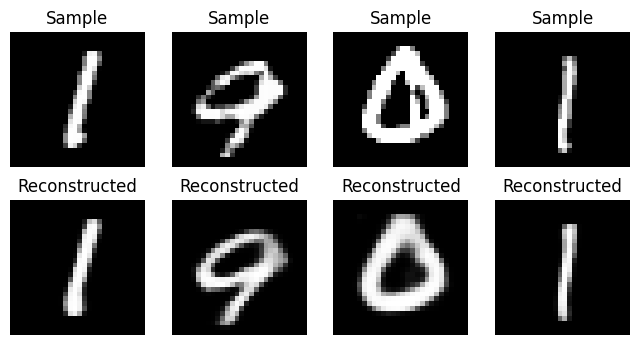

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 45 - Loss: 76.3844


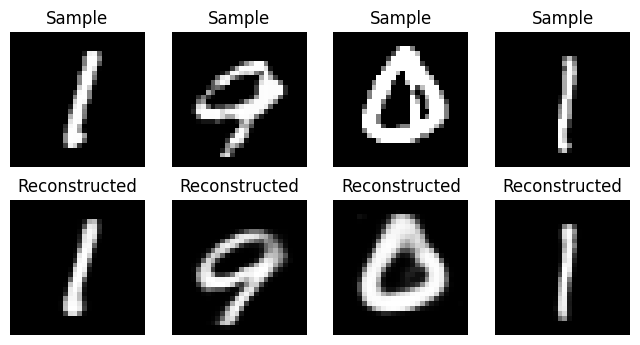

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 46 - Loss: 76.3365


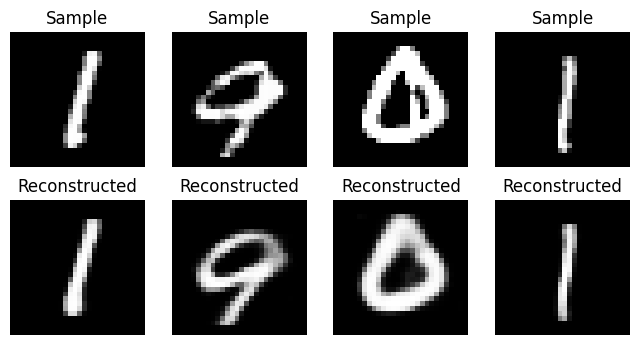

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 47 - Loss: 76.2868


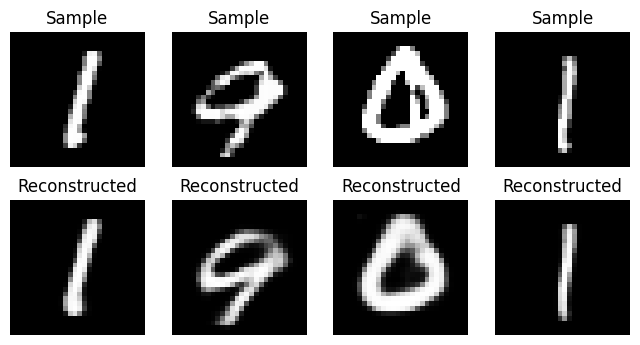

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 48 - Loss: 76.1910


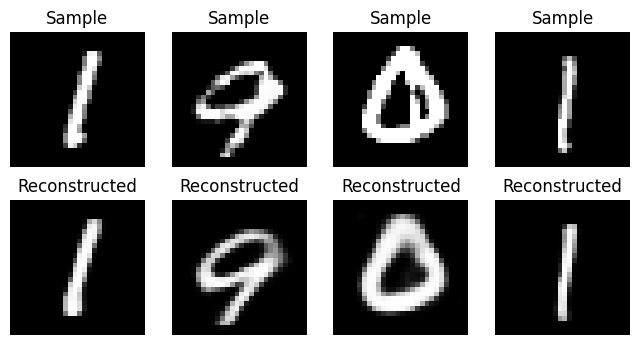

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 49 - Loss: 76.1821


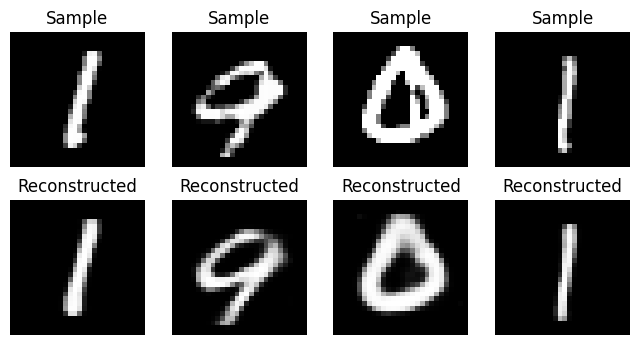

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 50 - Loss: 76.1148


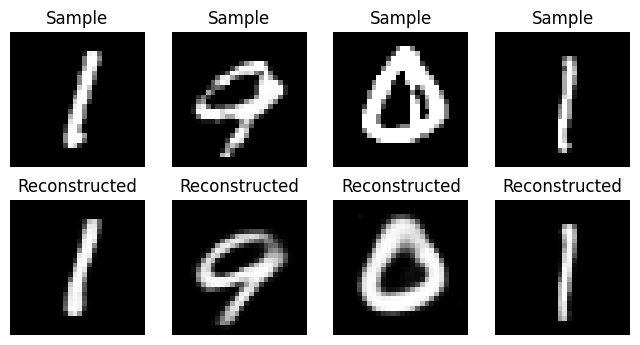

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 51 - Loss: 76.0043


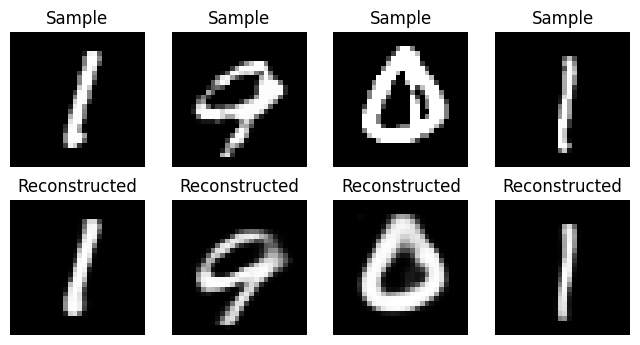

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 52 - Loss: 75.9748


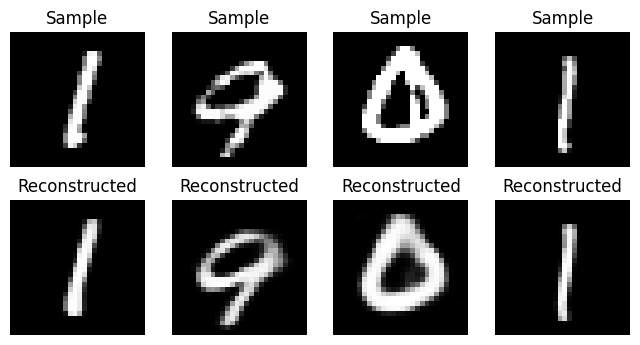

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 53 - Loss: 75.8829


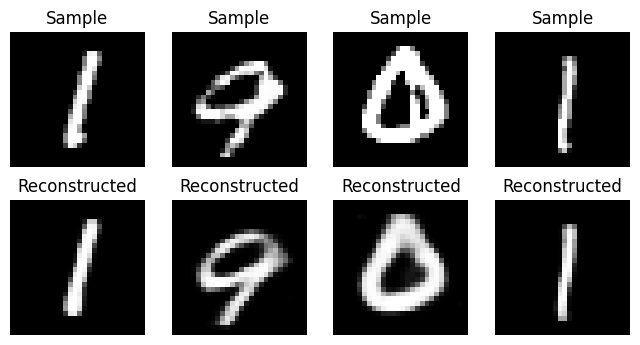

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 54 - Loss: 75.8736


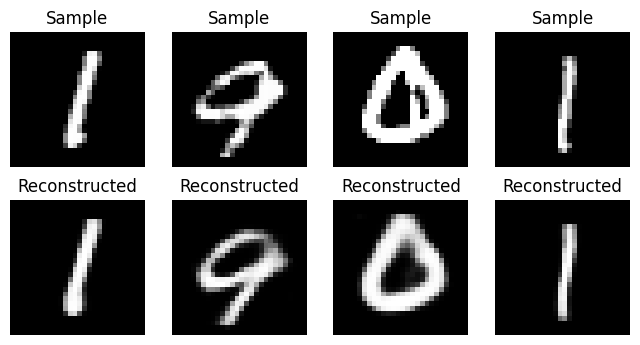

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 55 - Loss: 75.8006


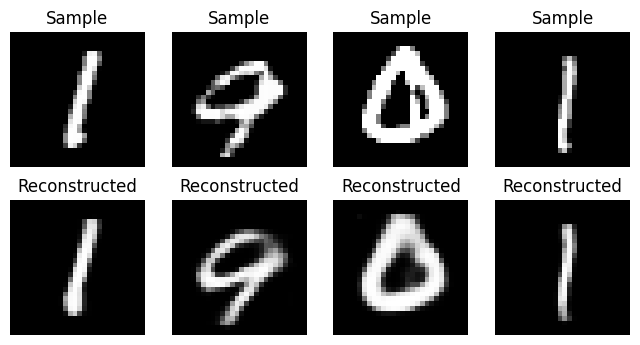

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 56 - Loss: 75.7544


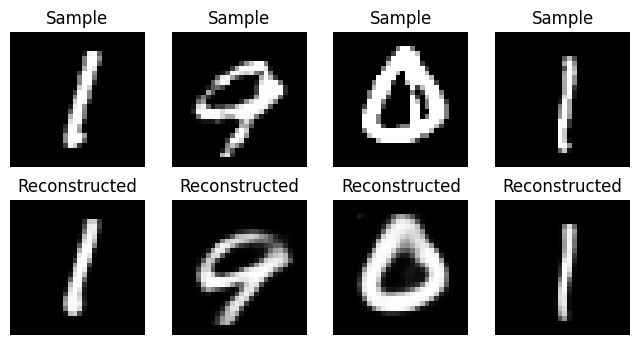

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 57 - Loss: 75.6903


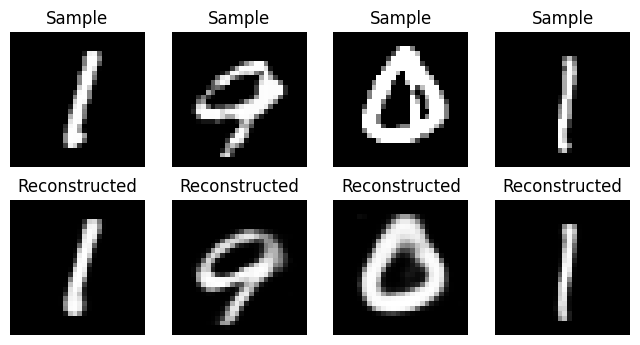

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 58 - Loss: 75.6534


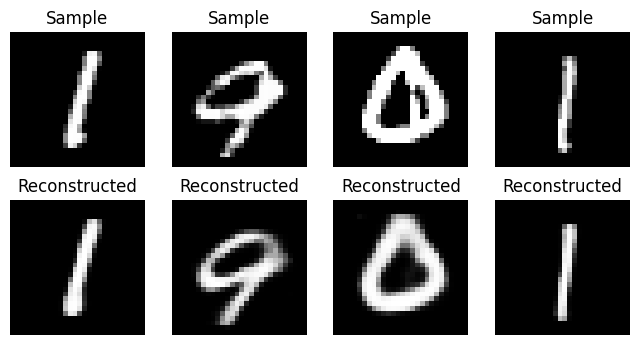

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 59 - Loss: 75.6208


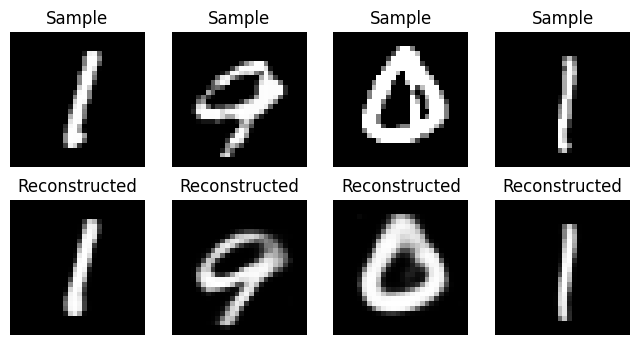

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 60 - Loss: 75.5512


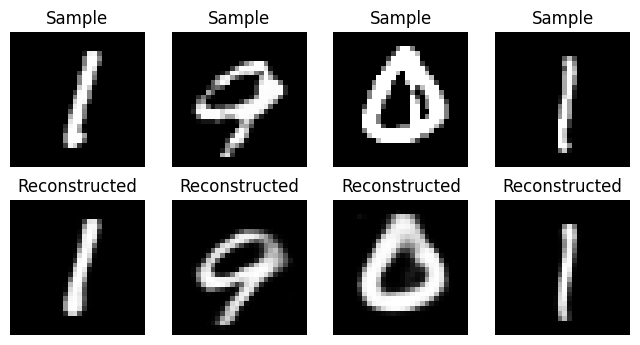

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 61 - Loss: 75.4880


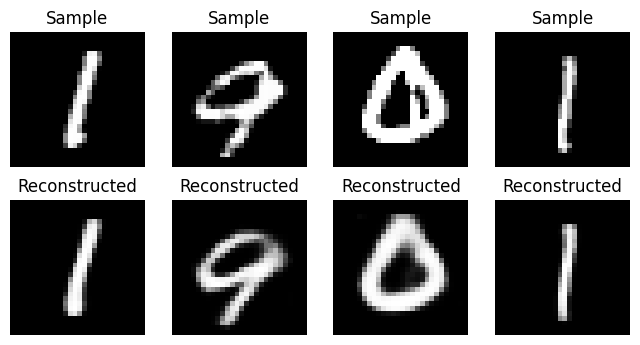

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 62 - Loss: 75.4294


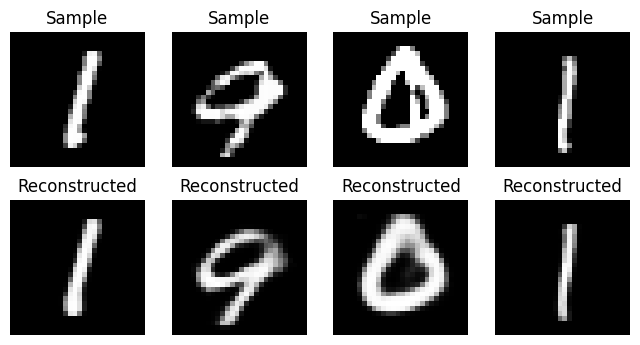

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 63 - Loss: 75.4265


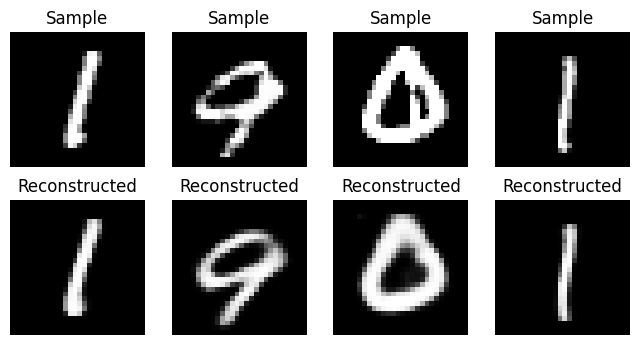

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 64 - Loss: 75.3769


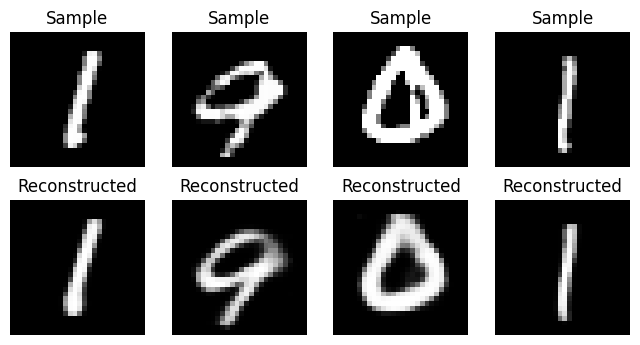

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 65 - Loss: 75.3091


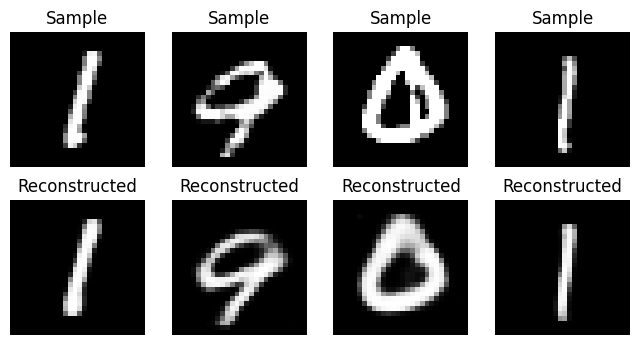

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 66 - Loss: 75.2917


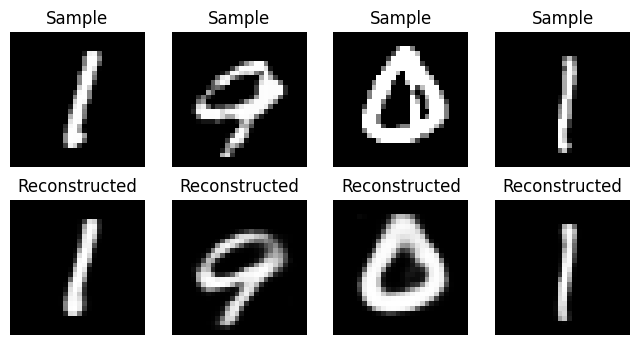

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 67 - Loss: 75.2345


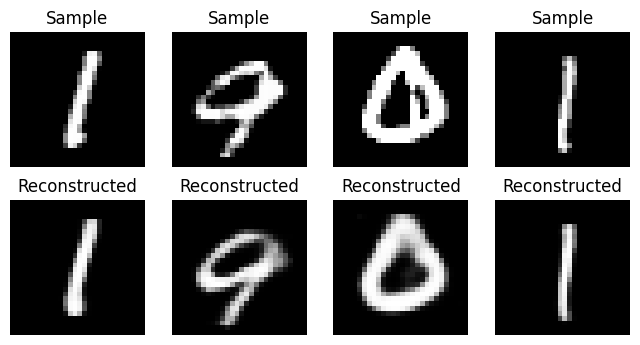

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 68 - Loss: 75.2191


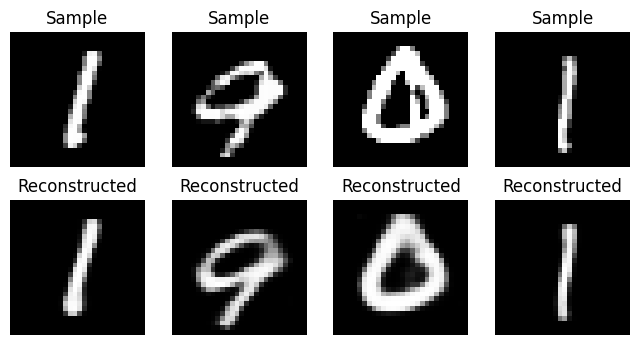

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 69 - Loss: 75.1406


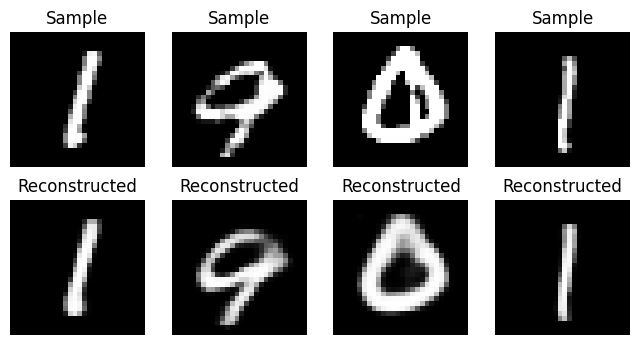

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 70 - Loss: 75.0993


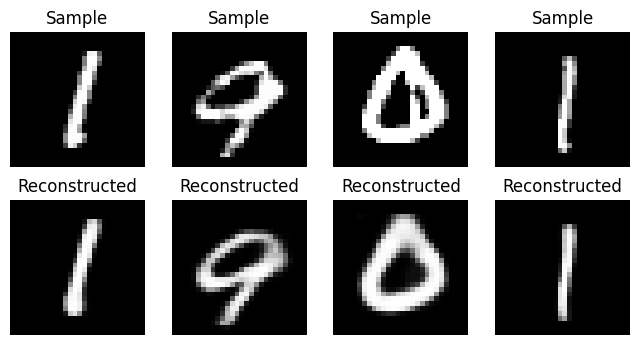

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 71 - Loss: 75.0868


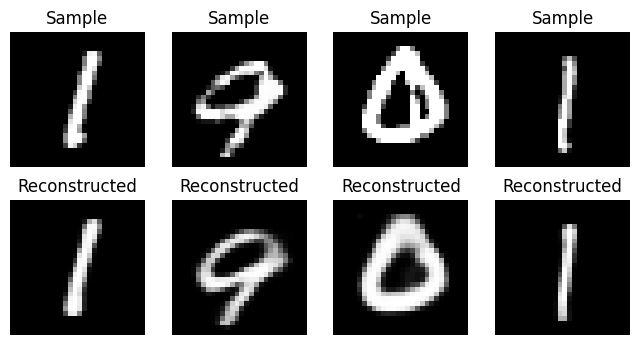

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 72 - Loss: 75.0462


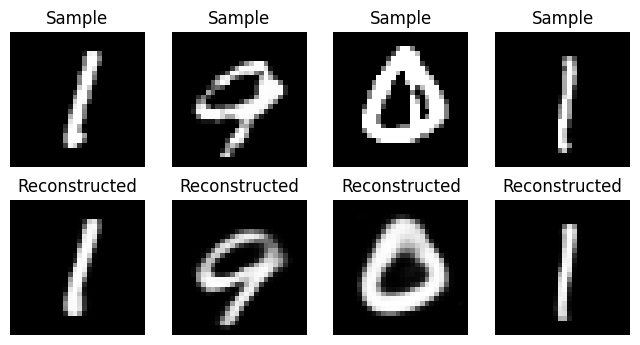

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 73 - Loss: 75.0129


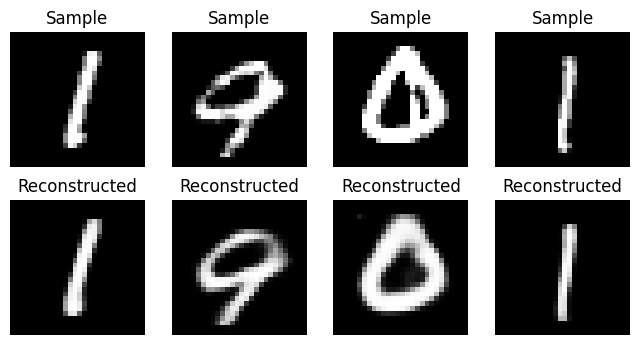

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 74 - Loss: 74.9703


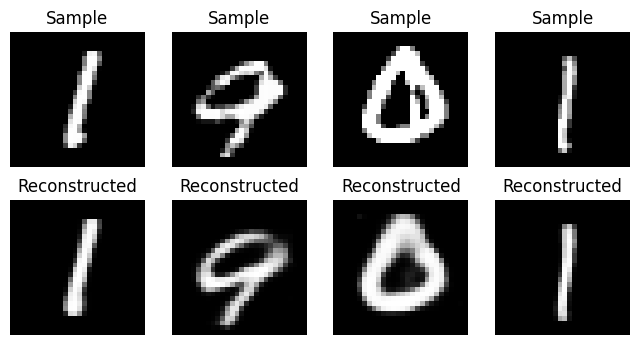

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 75 - Loss: 74.9383


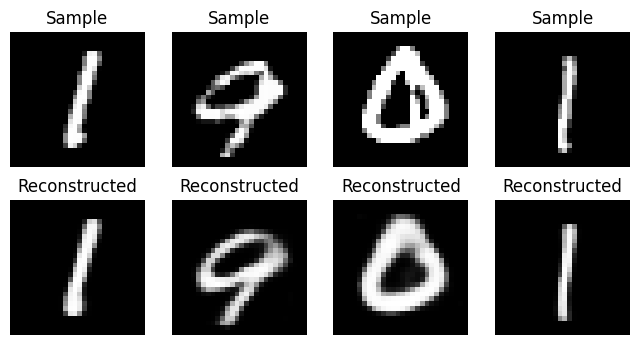

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 76 - Loss: 74.9092


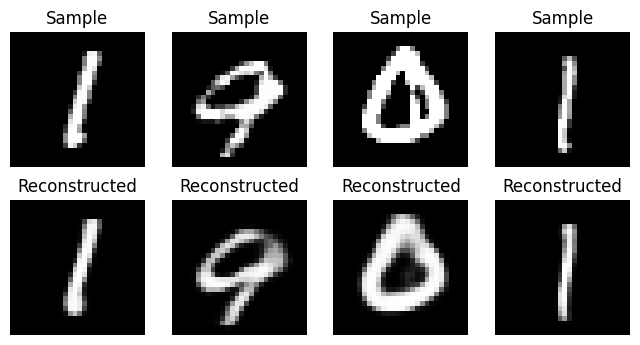

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 77 - Loss: 74.8744


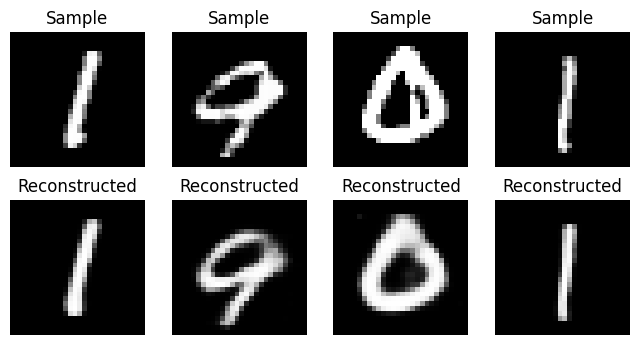

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 78 - Loss: 74.8243


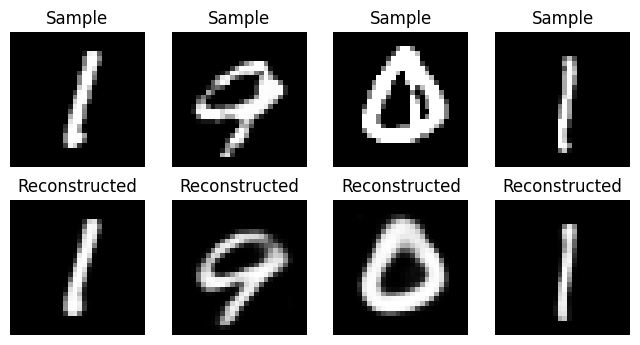

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 79 - Loss: 74.7925


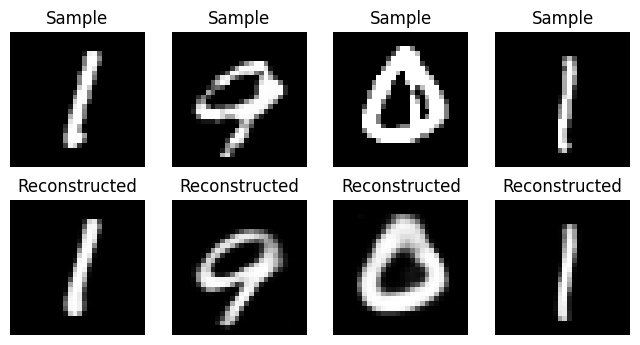

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 80 - Loss: 74.7974


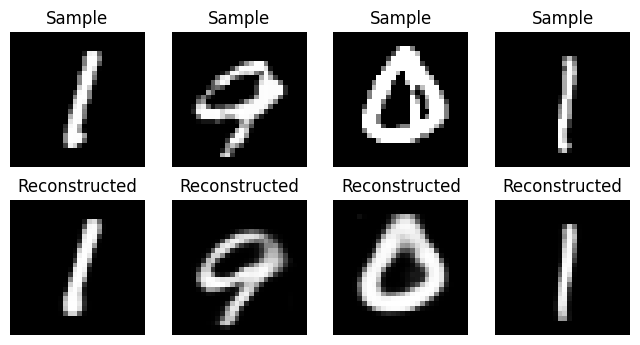

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 81 - Loss: 74.6982


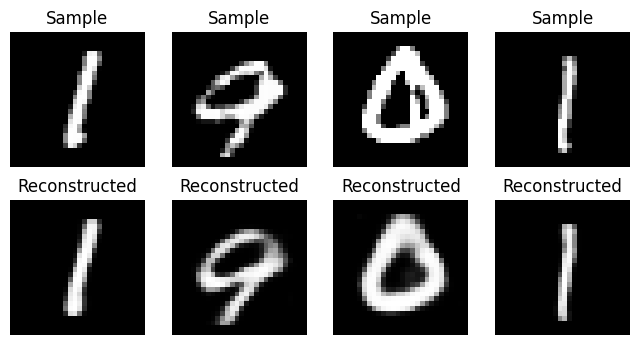

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 82 - Loss: 74.7039


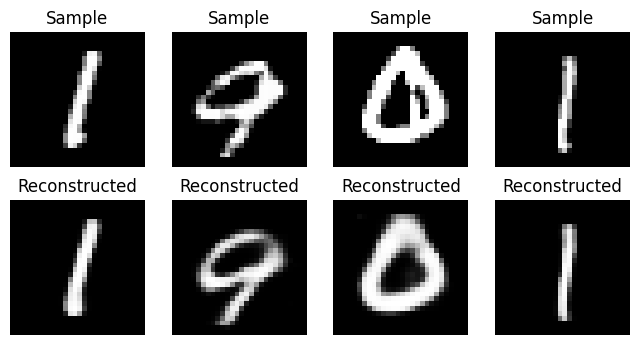

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 83 - Loss: 74.6665


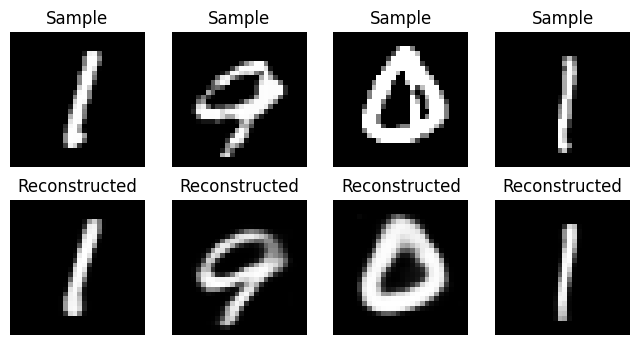

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 84 - Loss: 74.6340


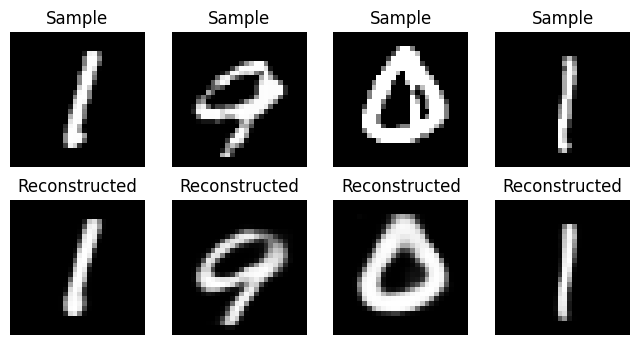

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 85 - Loss: 74.6618


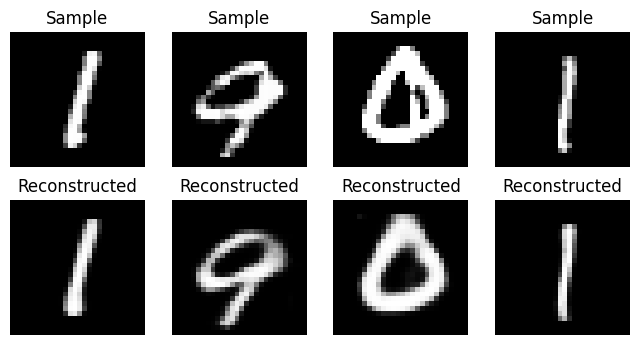

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 86 - Loss: 74.6142


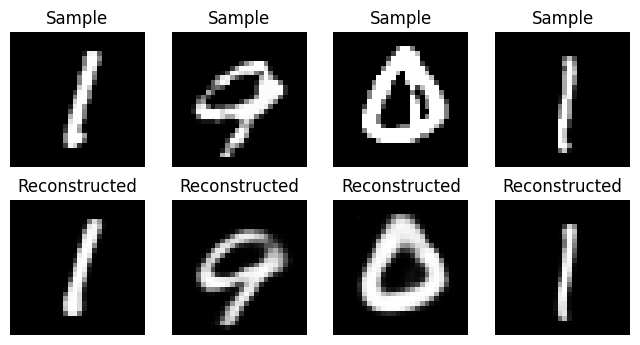

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 87 - Loss: 74.5780


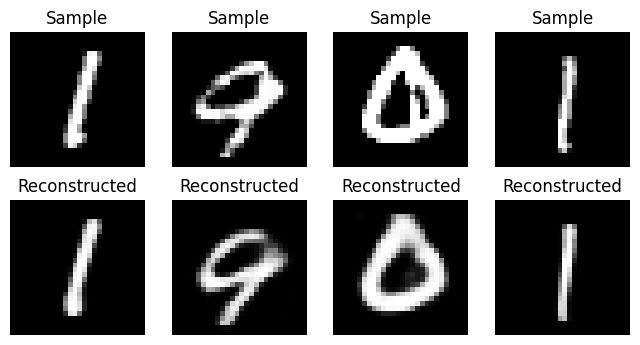

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 88 - Loss: 74.5319


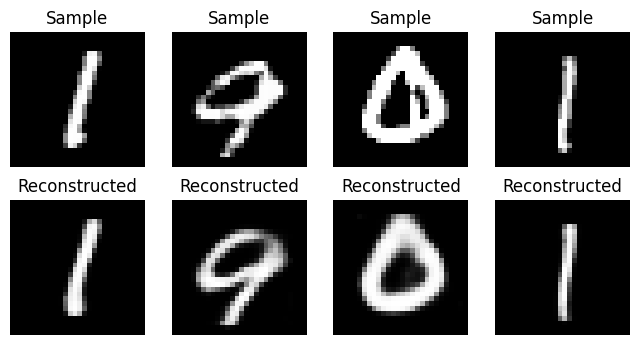

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 89 - Loss: 74.5511


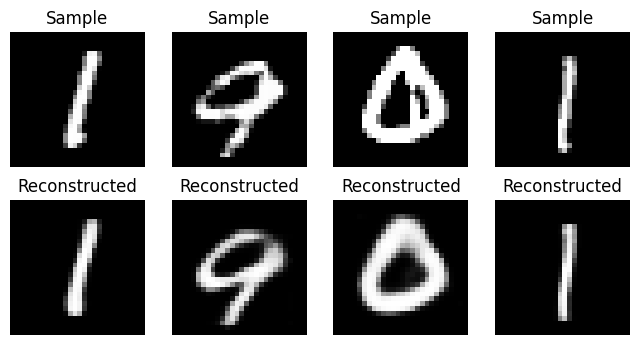

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 90 - Loss: 74.4460


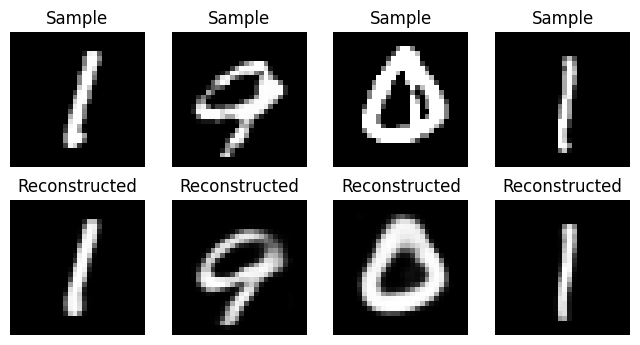

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 91 - Loss: 74.4654


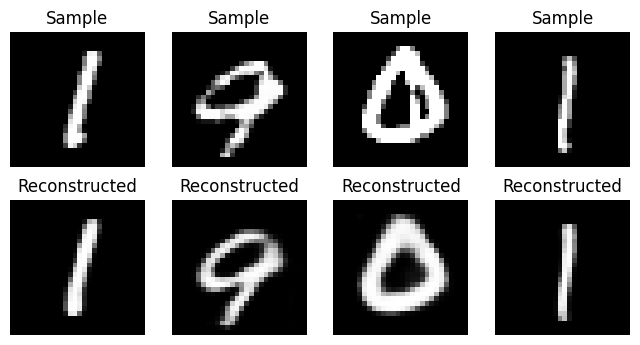

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 92 - Loss: 74.4457


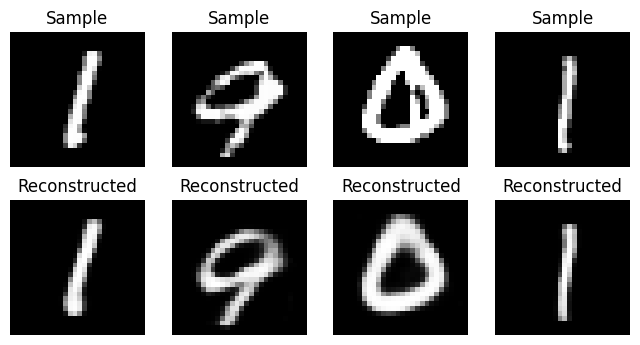

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 93 - Loss: 74.4448


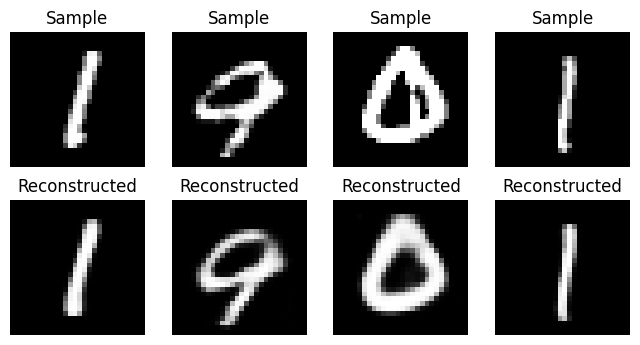

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 94 - Loss: 74.3689


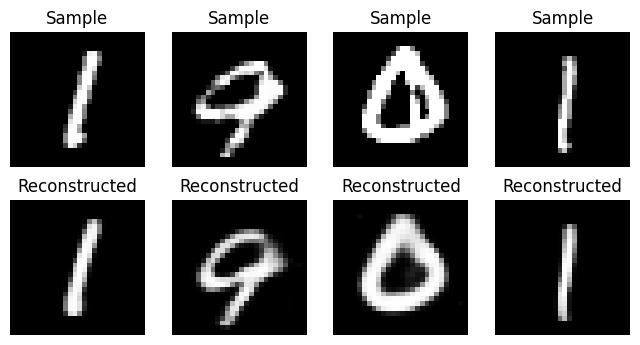

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 95 - Loss: 74.3603


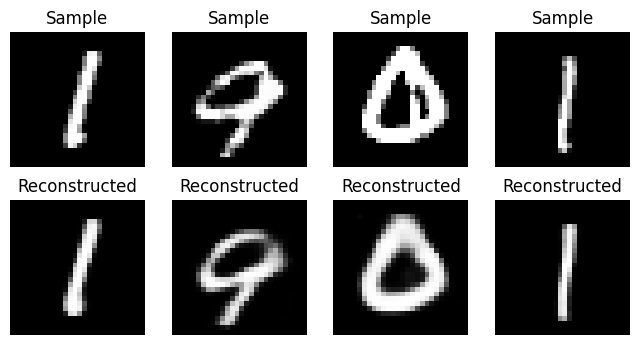

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 96 - Loss: 74.3217


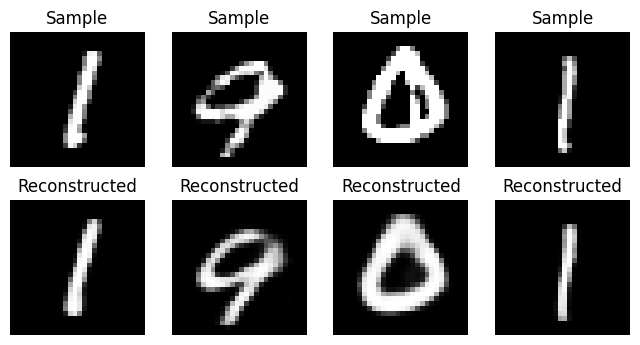

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 97 - Loss: 74.3044


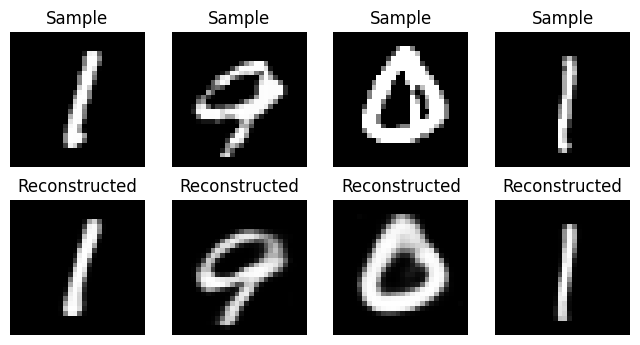

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 98 - Loss: 74.3046


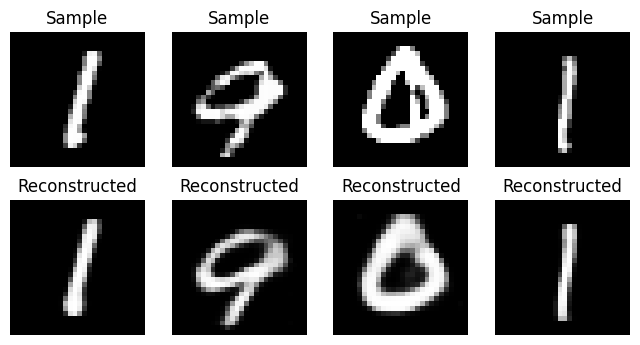

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 99 - Loss: 74.2374


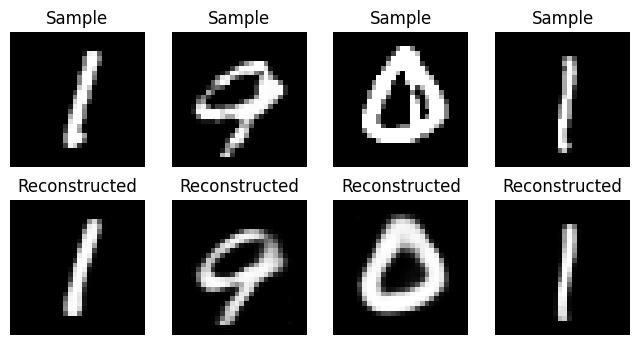

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 100 - Loss: 74.2749


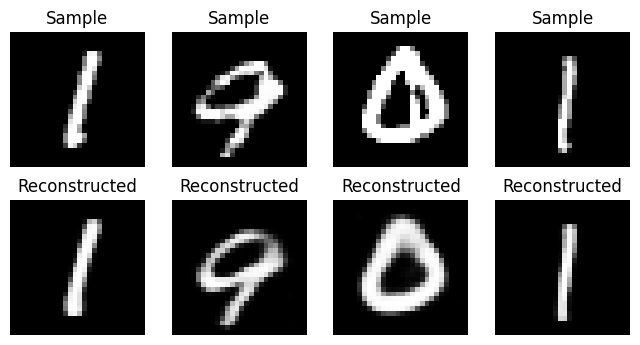

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 101 - Loss: 74.2279


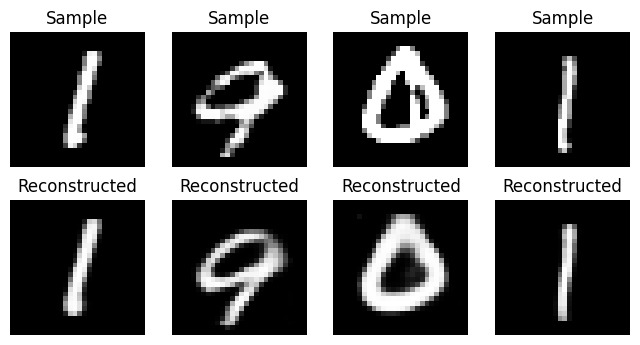

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 102 - Loss: 74.1714


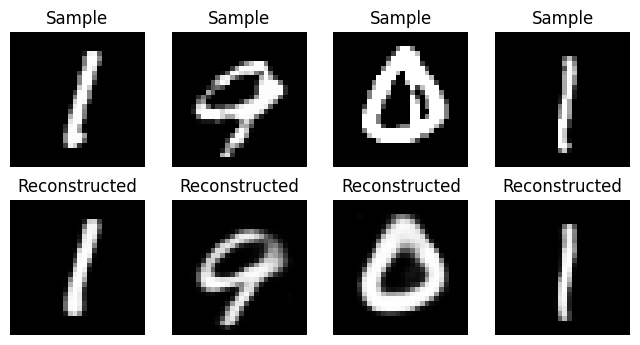

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 103 - Loss: 74.1984


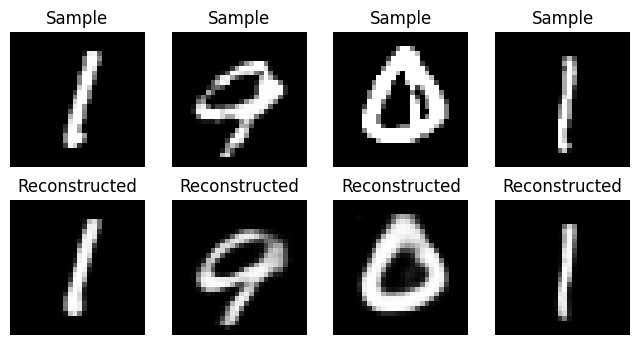

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 104 - Loss: 74.1433


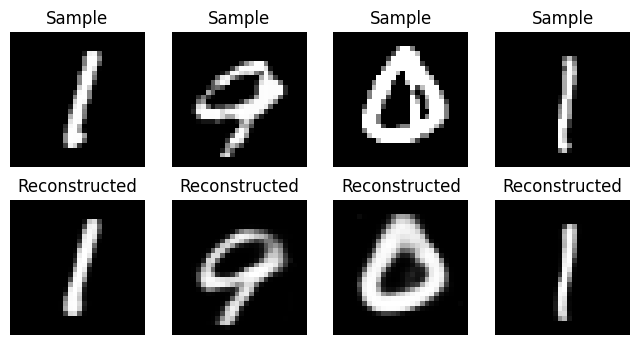

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 105 - Loss: 74.1464


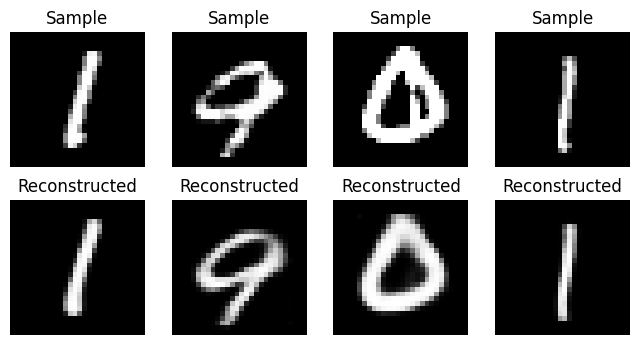

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 106 - Loss: 74.1007


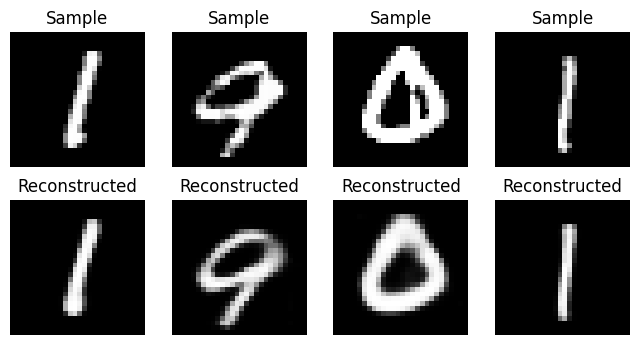

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 107 - Loss: 74.0756


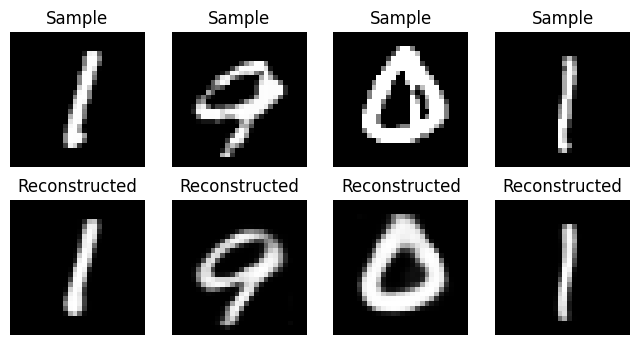

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 108 - Loss: 74.0801


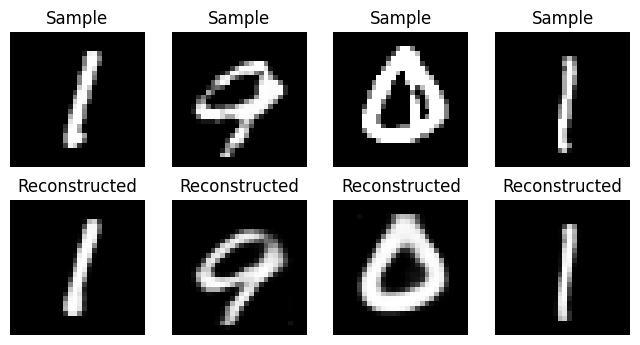

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 109 - Loss: 74.0844


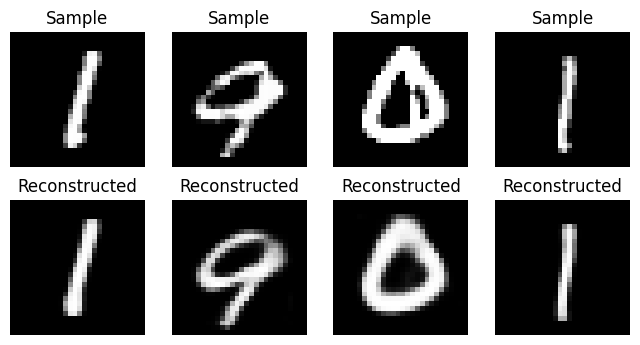

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 110 - Loss: 74.0068


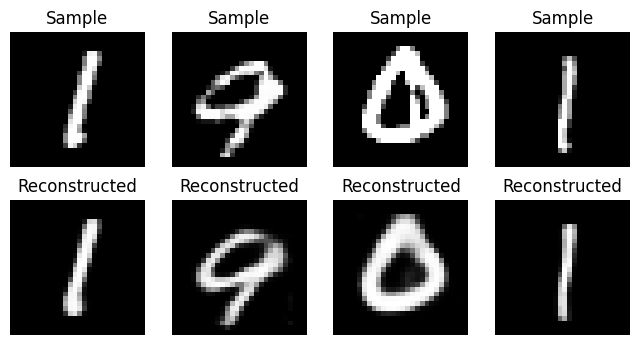

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 111 - Loss: 74.0337


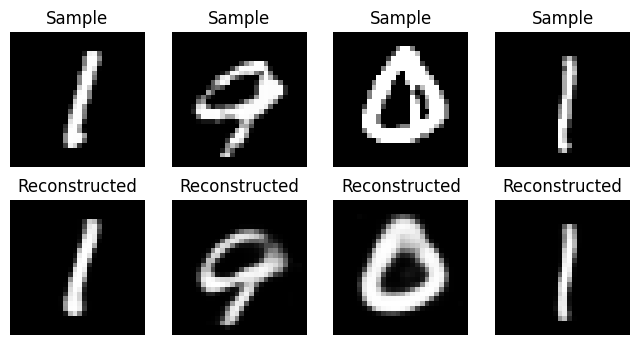

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 112 - Loss: 73.9986


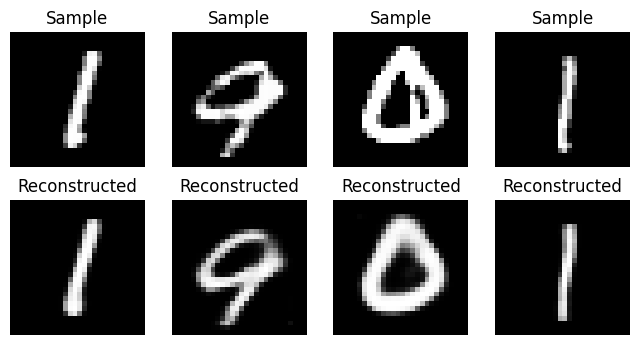

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 113 - Loss: 73.9658


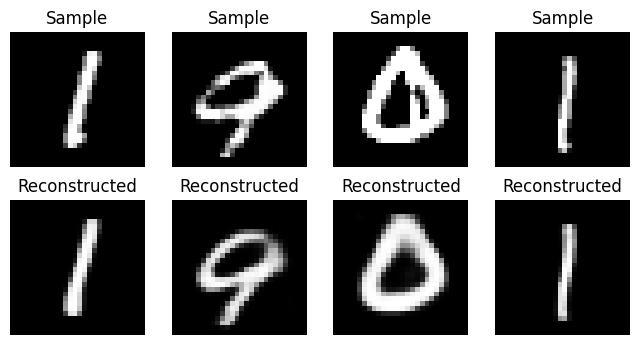

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 114 - Loss: 73.9443


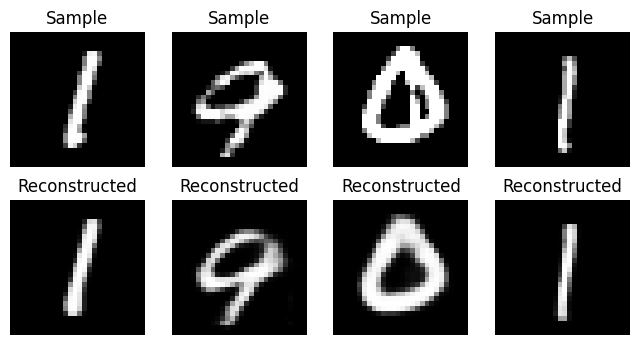

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 115 - Loss: 73.9314


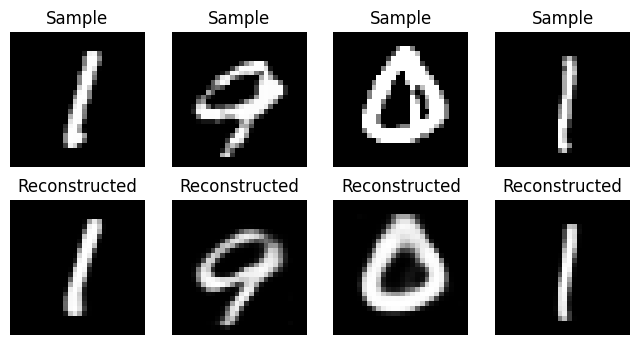

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 116 - Loss: 73.9593


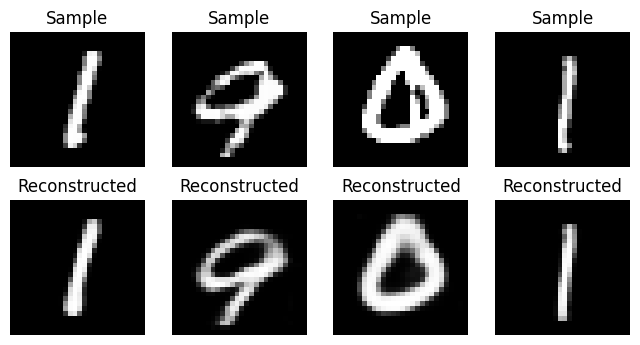

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 117 - Loss: 73.9005


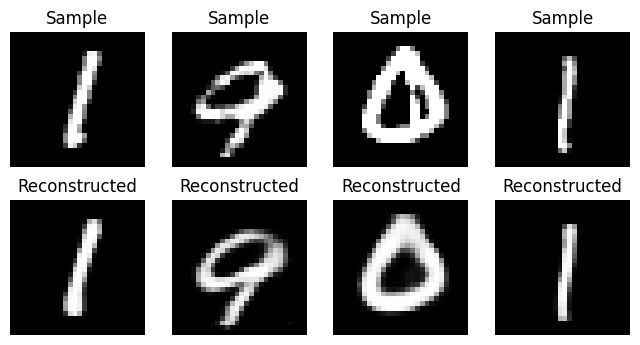

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 118 - Loss: 73.8824


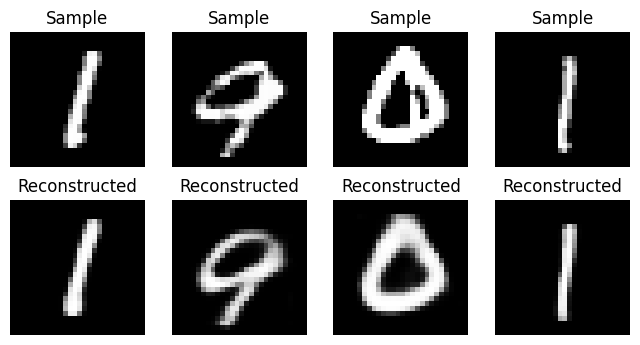

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 119 - Loss: 73.8797


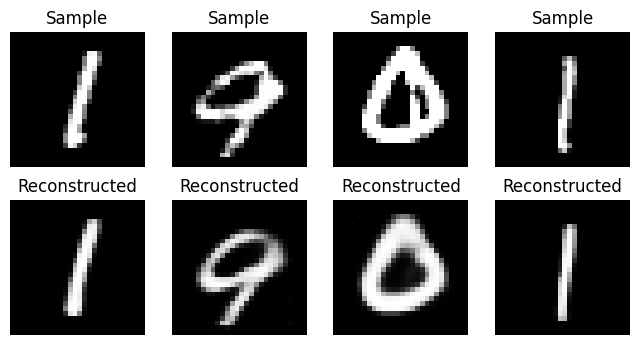

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 120 - Loss: 73.8038


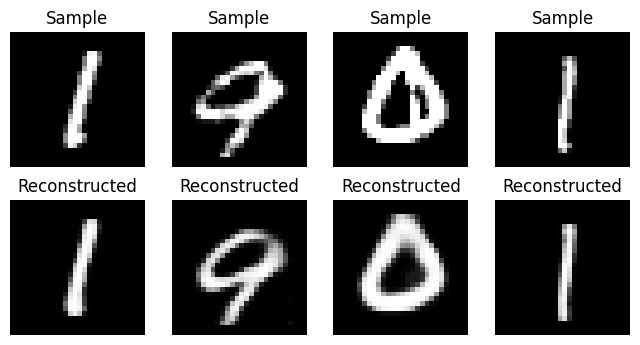

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 121 - Loss: 73.8526


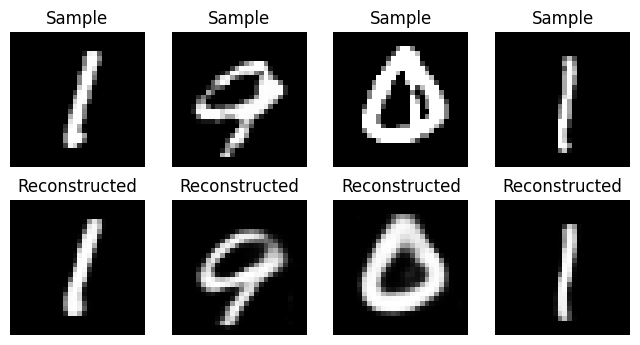

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 122 - Loss: 73.8482


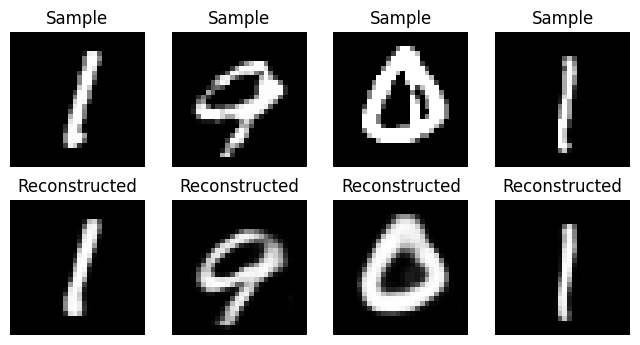

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 123 - Loss: 73.7867


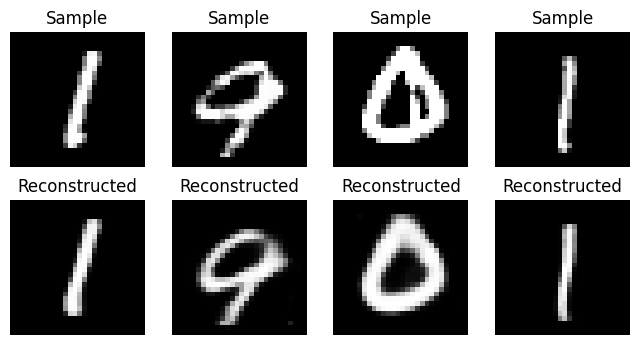

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 124 - Loss: 73.8000


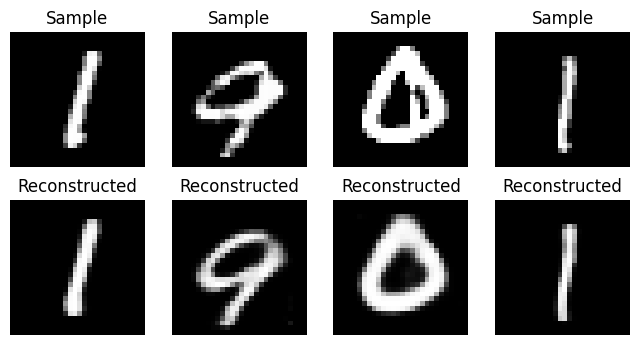

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 125 - Loss: 73.7554


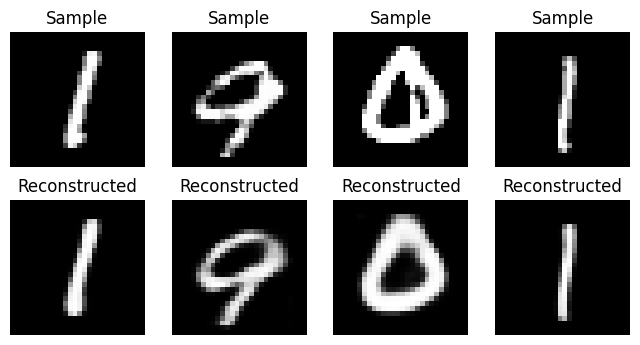

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 126 - Loss: 73.7430


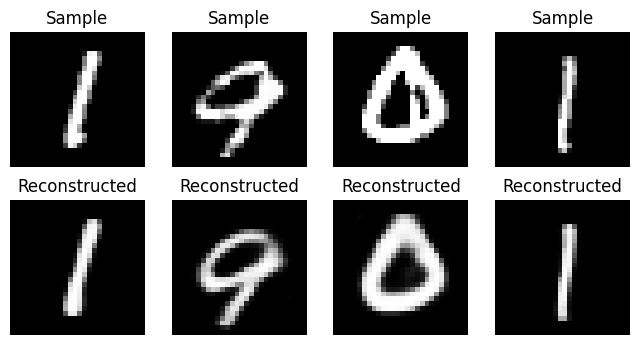

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 127 - Loss: 73.7271


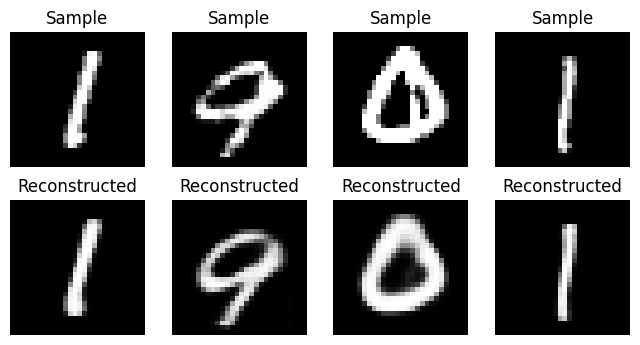

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 128 - Loss: 73.7416


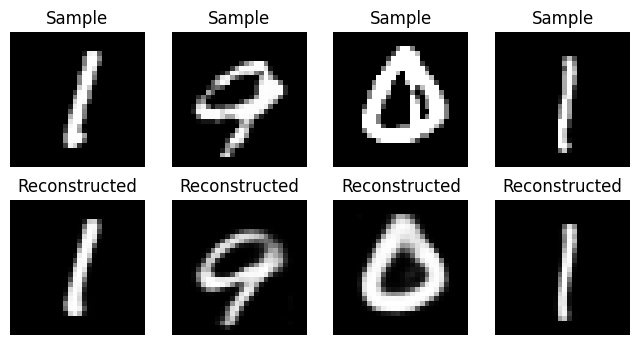

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 129 - Loss: 73.6686


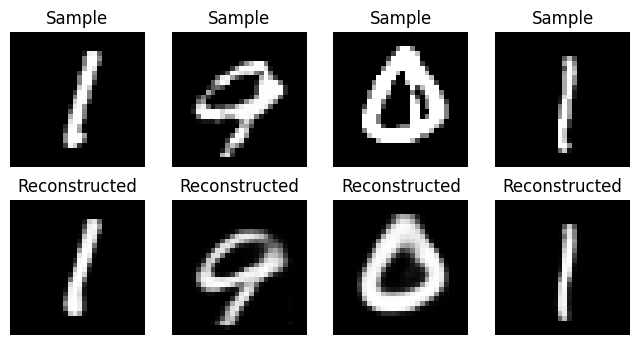

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 130 - Loss: 73.6601


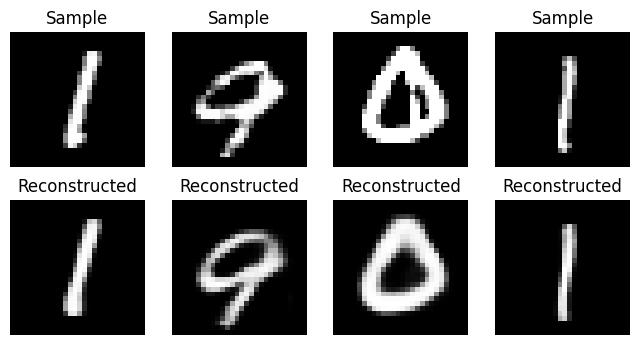

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 131 - Loss: 73.6750


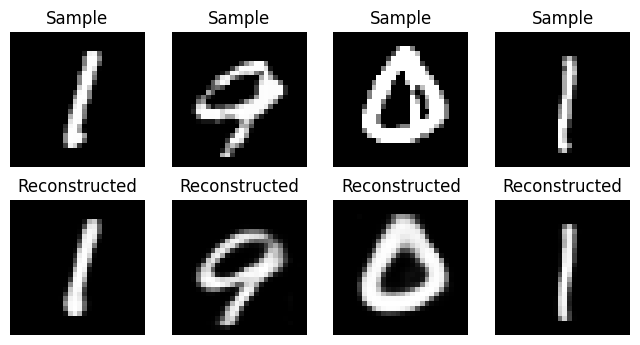

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 132 - Loss: 73.6462


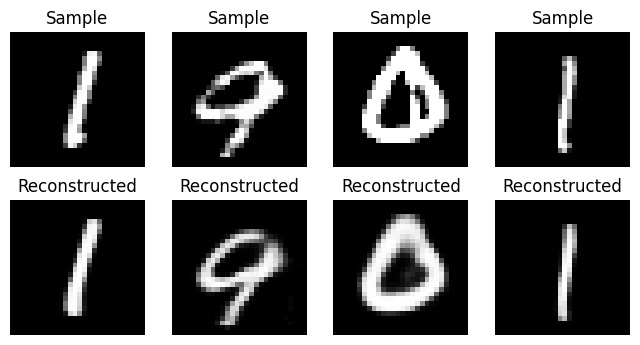

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 133 - Loss: 73.6424


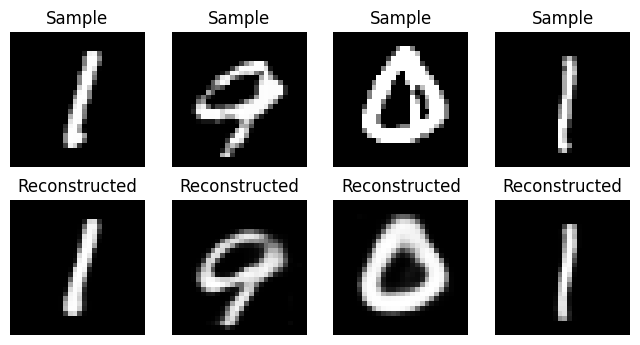

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 134 - Loss: 73.6355


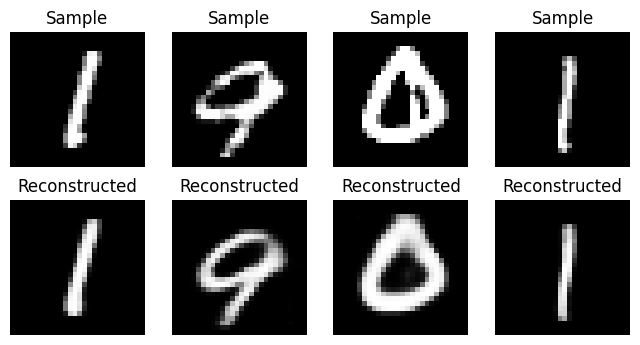

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 135 - Loss: 73.5866


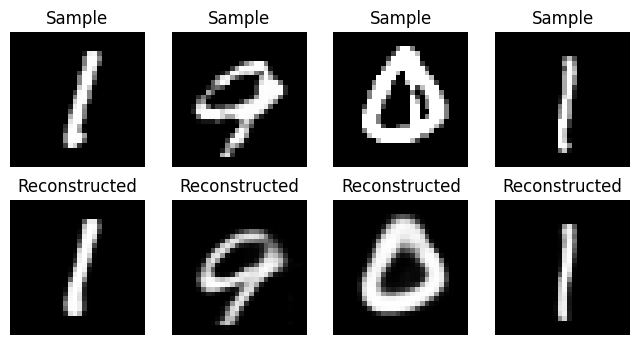

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 136 - Loss: 73.5710


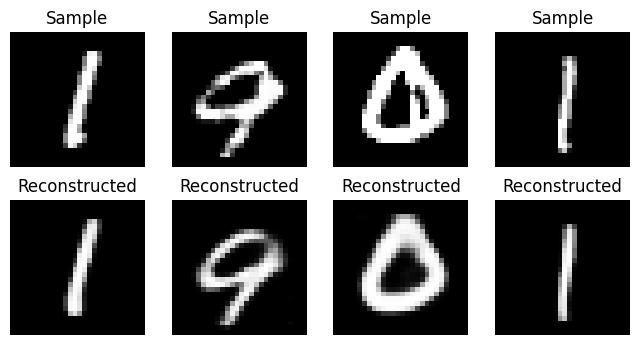

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 137 - Loss: 73.5930


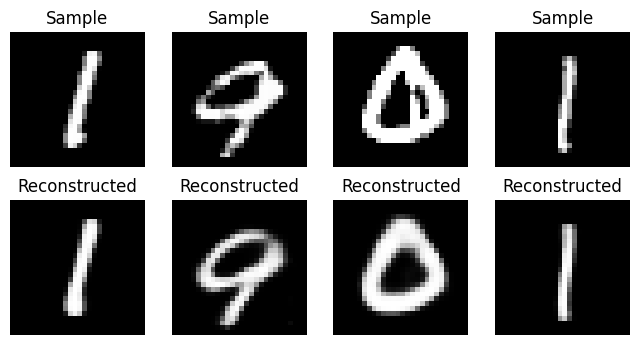

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 138 - Loss: 73.5323


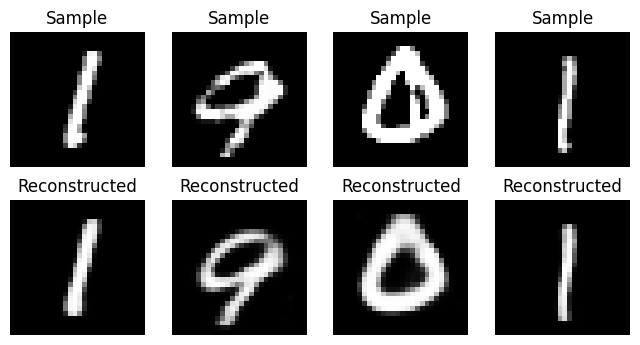

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 139 - Loss: 73.5700


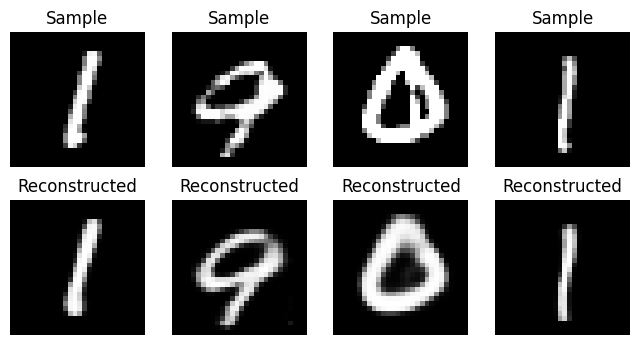

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 140 - Loss: 73.4979


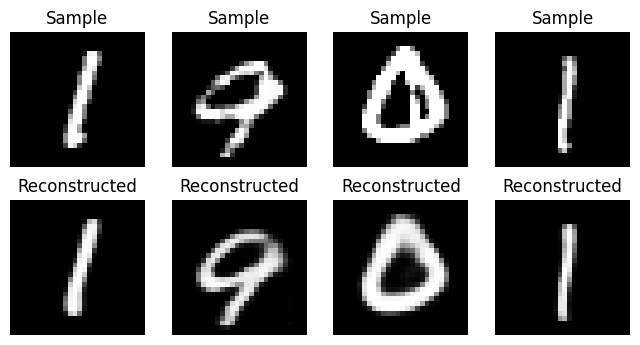

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 141 - Loss: 73.5161


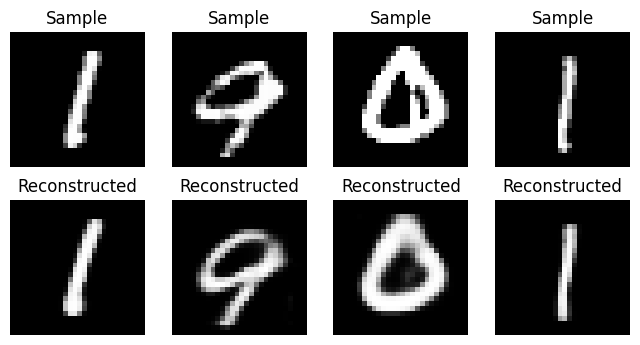

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 142 - Loss: 73.5218


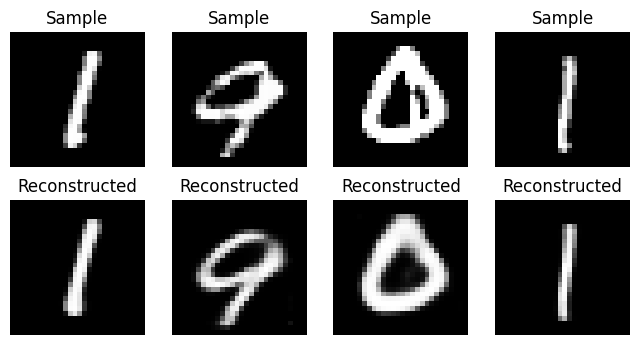

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 143 - Loss: 73.5252


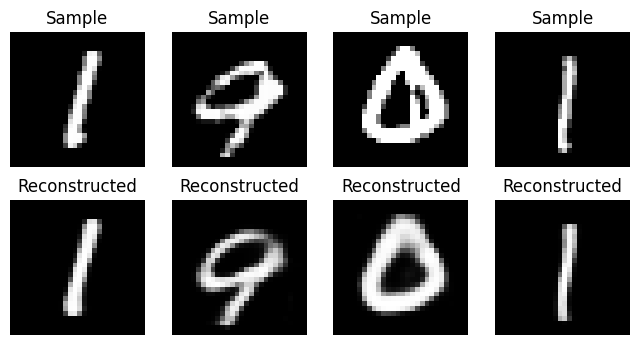

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 144 - Loss: 73.4597


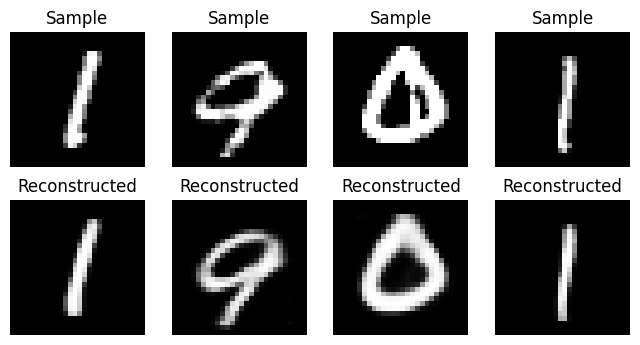

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 145 - Loss: 73.4925


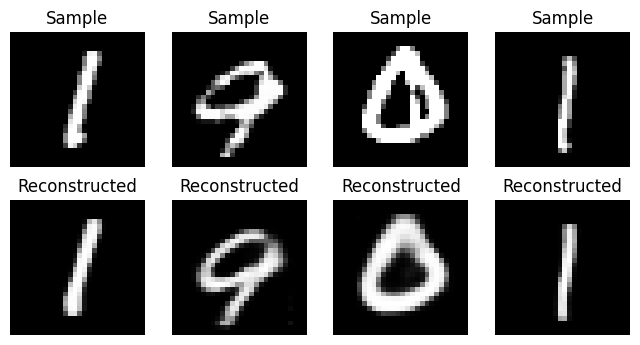

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 146 - Loss: 73.4424


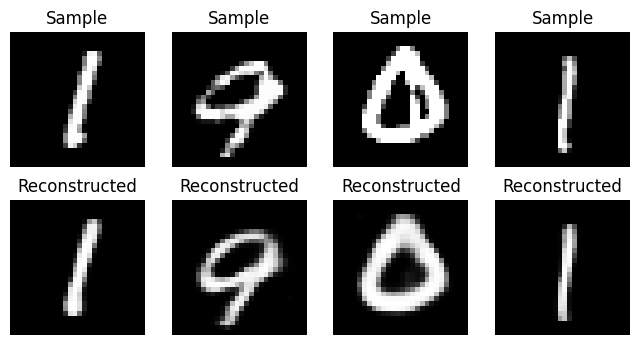

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 147 - Loss: 73.4903


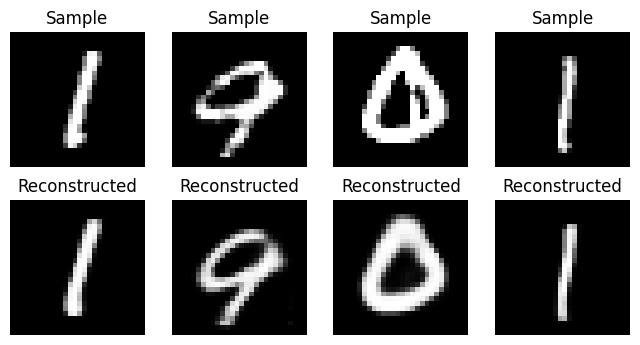

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 148 - Loss: 73.3923


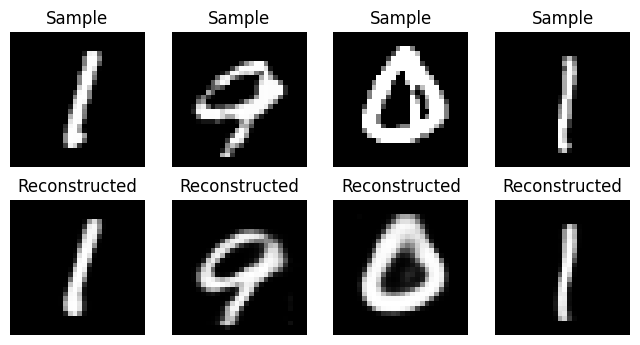

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 149 - Loss: 73.4487


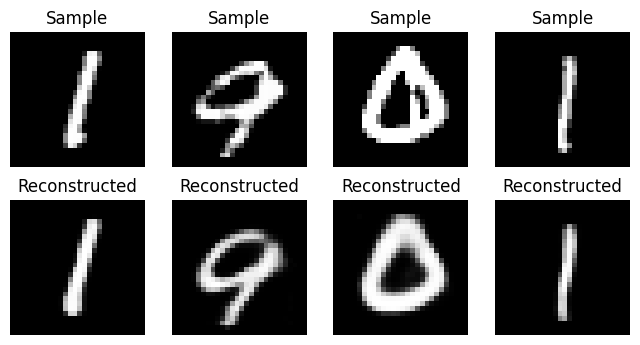

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 150 - Loss: 73.3910


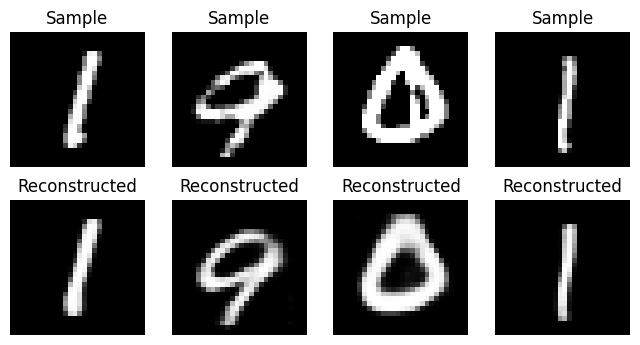

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 151 - Loss: 73.4117


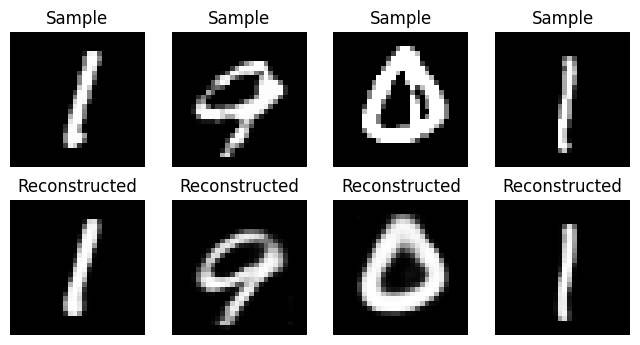

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 152 - Loss: 73.3717


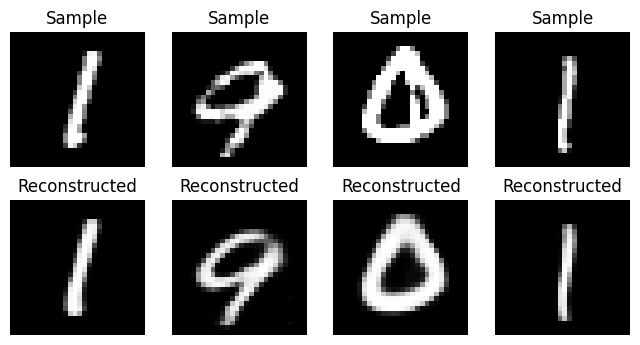

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 153 - Loss: 73.3469


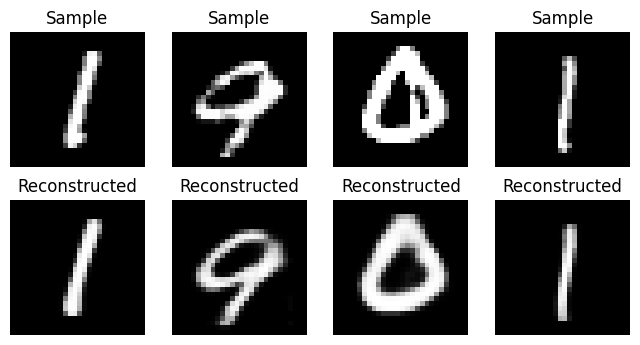

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 154 - Loss: 73.3541


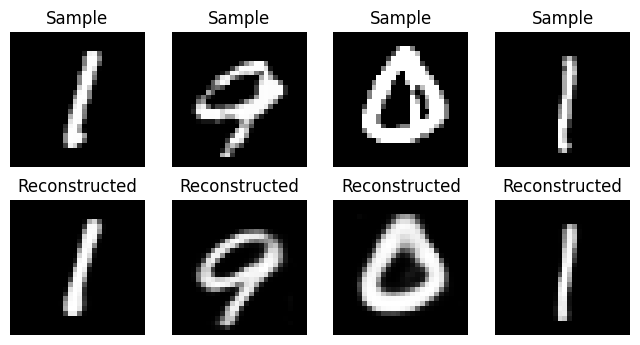

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 155 - Loss: 73.3419


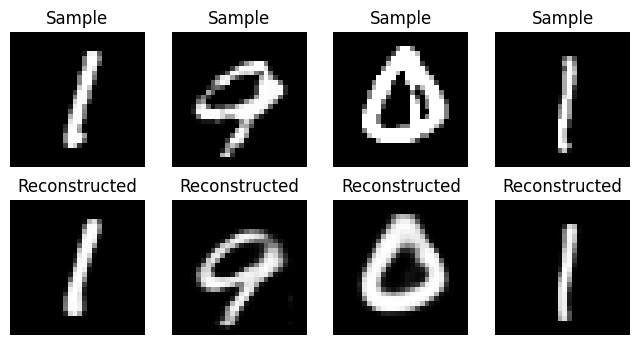

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 156 - Loss: 73.3425


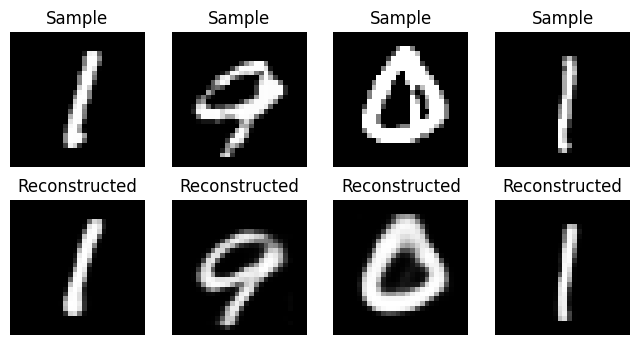

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 157 - Loss: 73.3573


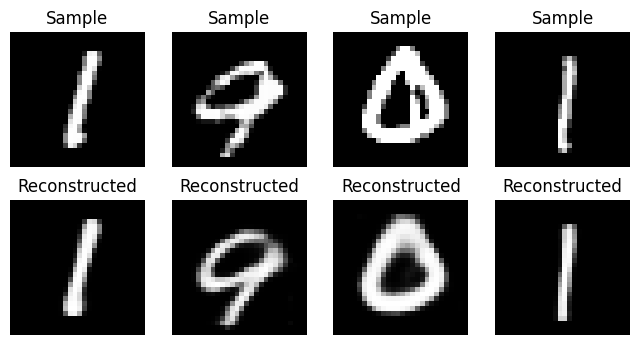

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 158 - Loss: 73.2908


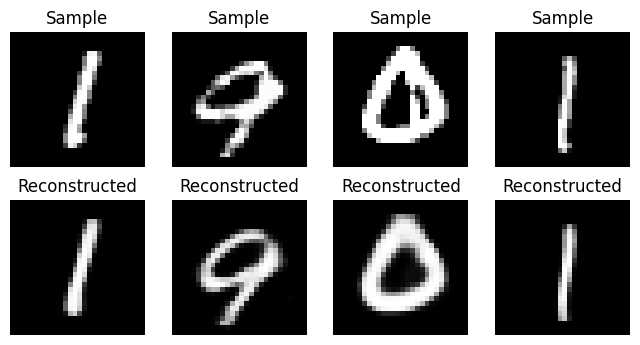

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 159 - Loss: 73.2703


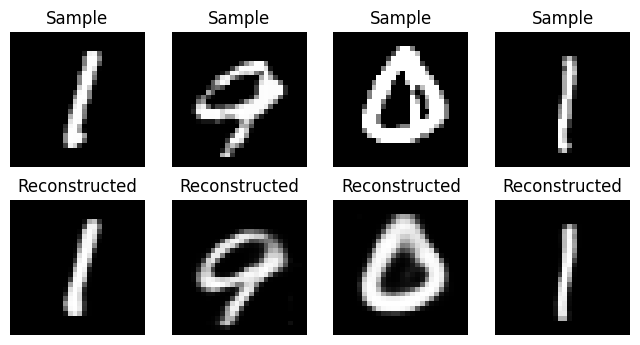

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 160 - Loss: 73.3208


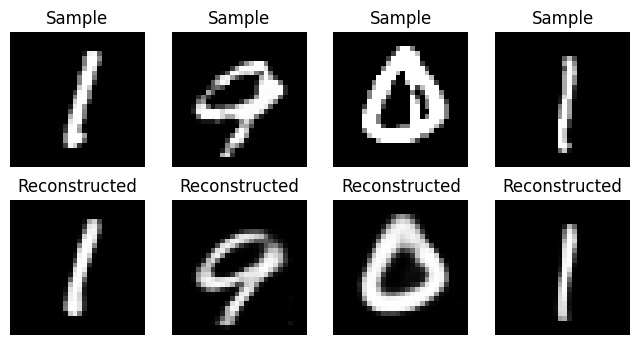

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 161 - Loss: 73.2878


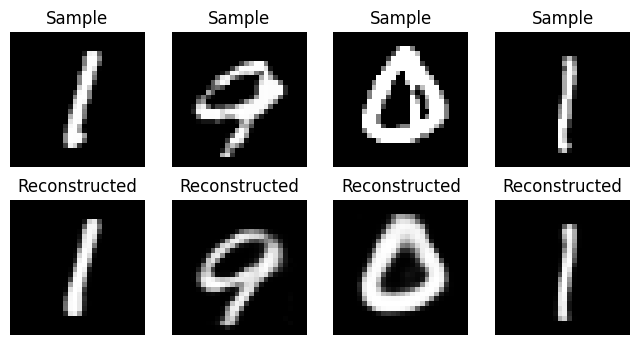

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 162 - Loss: 73.2271


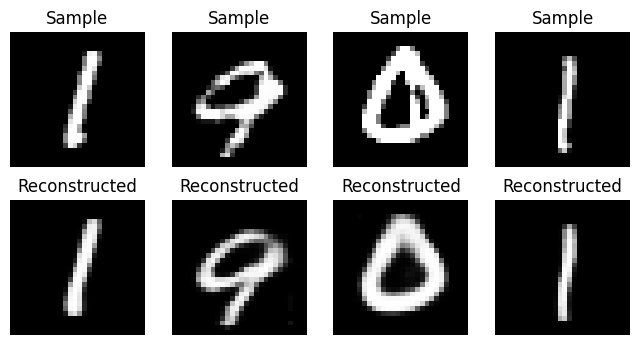

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 163 - Loss: 73.2623


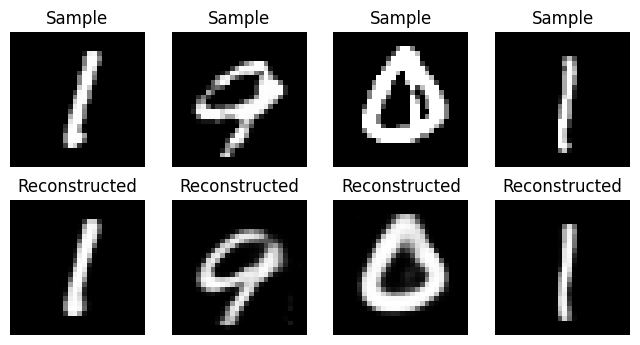

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 164 - Loss: 73.2600


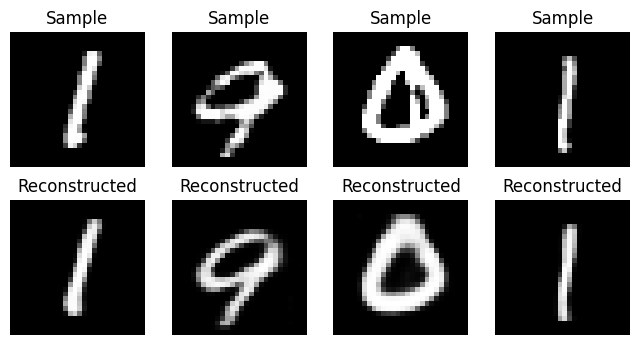

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 165 - Loss: 73.2291


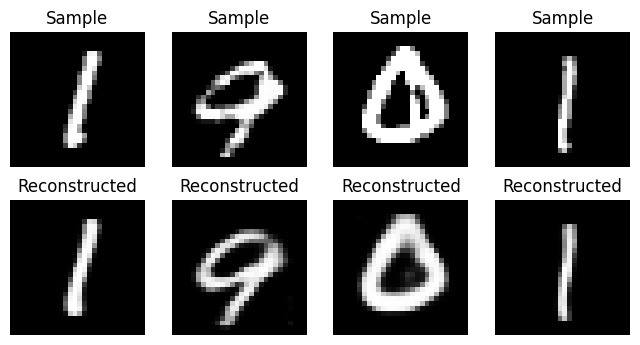

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 166 - Loss: 73.2161


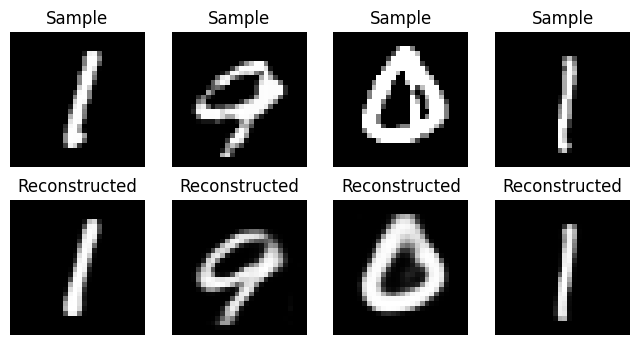

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 167 - Loss: 73.2250


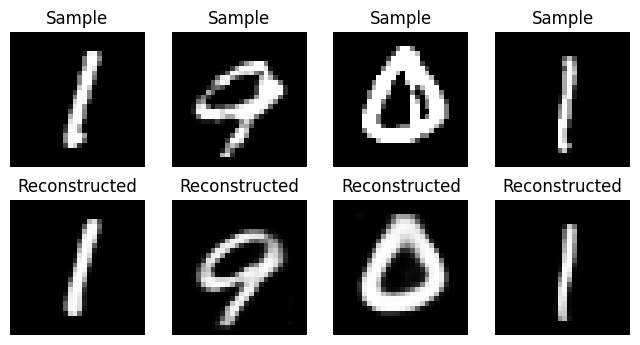

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 168 - Loss: 73.1954


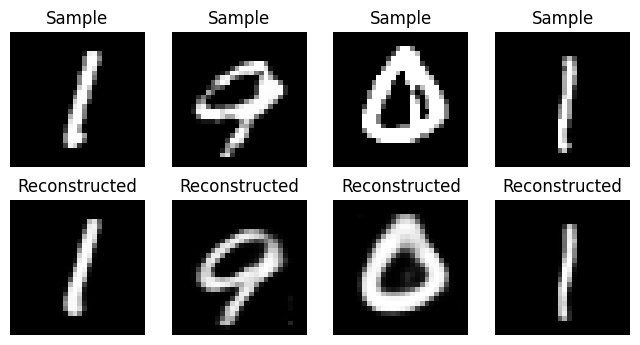

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 169 - Loss: 73.1803


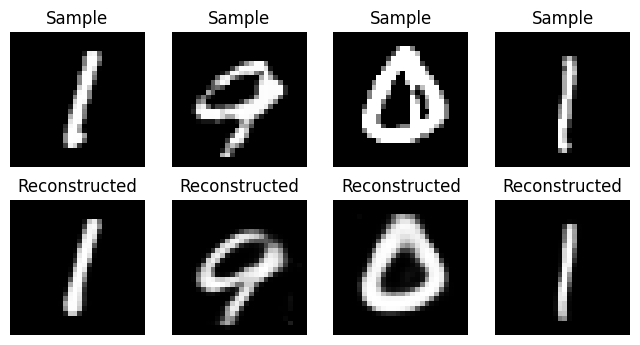

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 170 - Loss: 73.1608


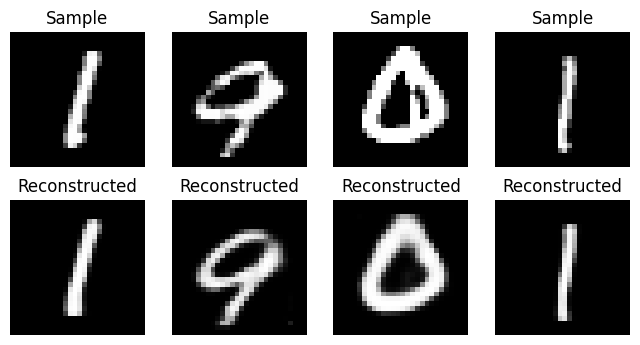

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 171 - Loss: 73.2188


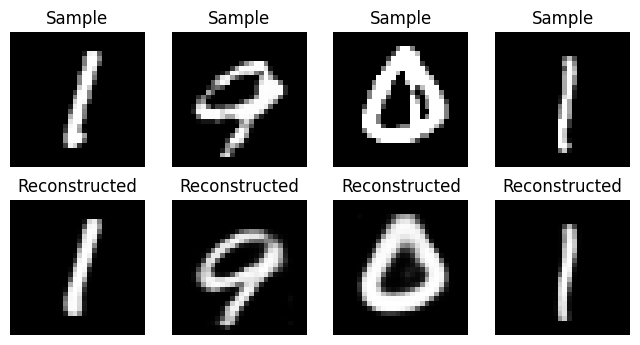

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 172 - Loss: 73.1451


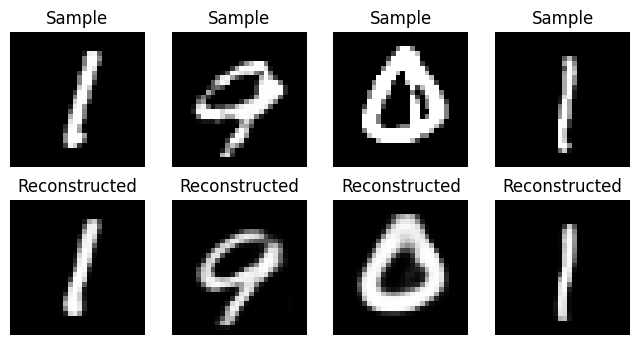

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 173 - Loss: 73.1337


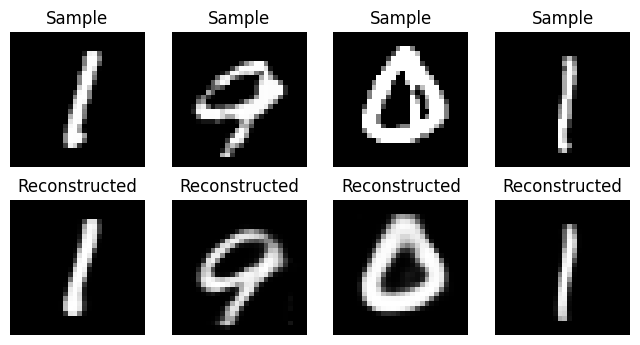

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 174 - Loss: 73.1436


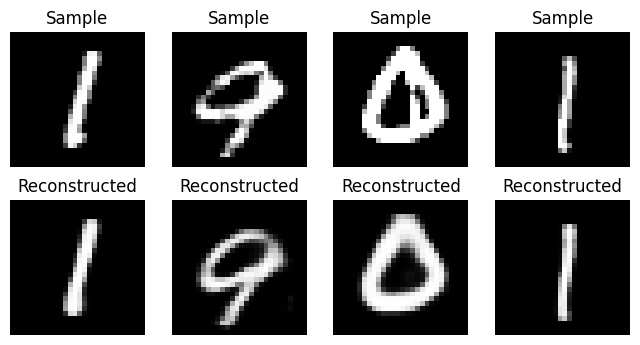

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 175 - Loss: 73.1500


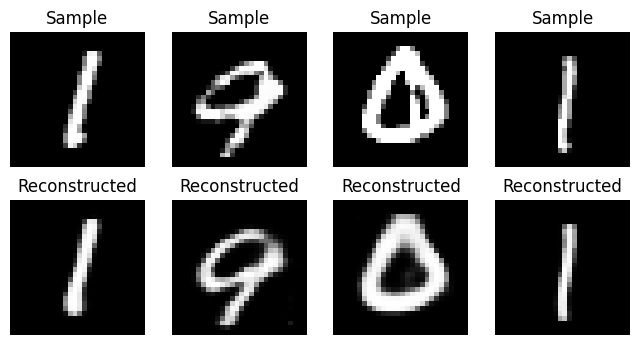

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 176 - Loss: 73.1090


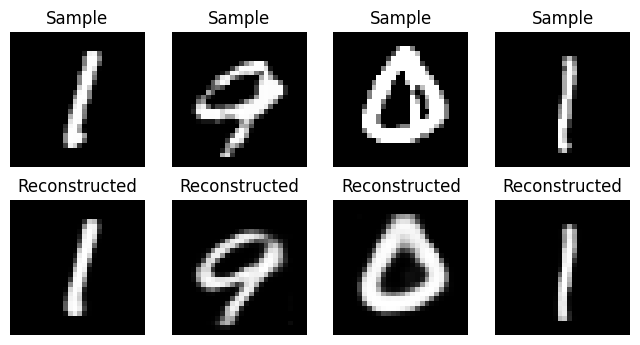

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 177 - Loss: 73.1266


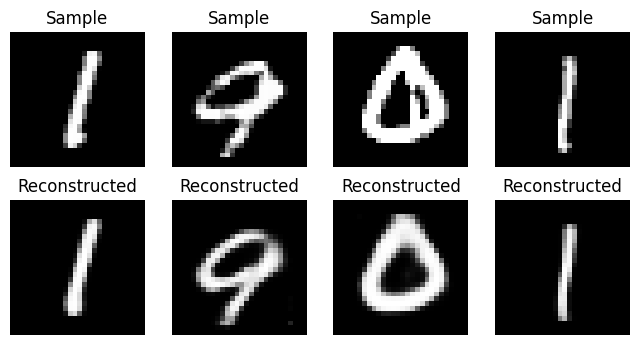

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 178 - Loss: 73.0716


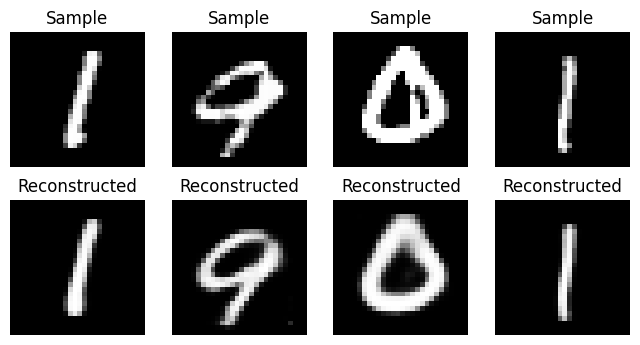

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 179 - Loss: 73.1357


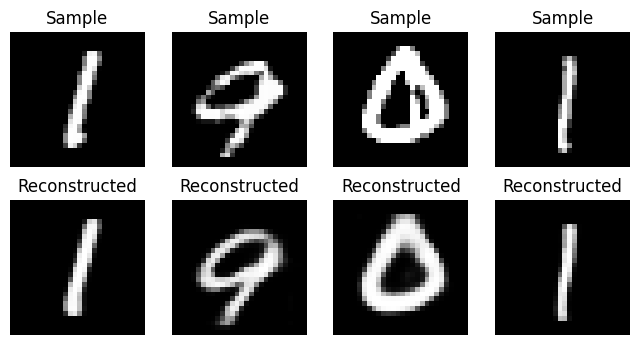

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 180 - Loss: 73.1179


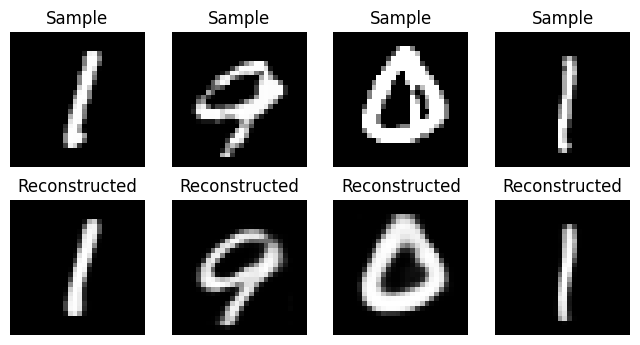

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 181 - Loss: 73.0428


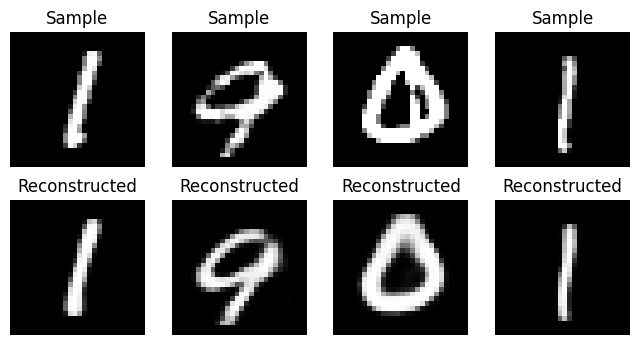

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 182 - Loss: 73.0584


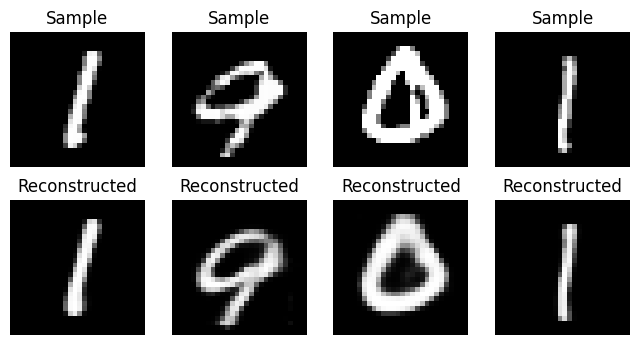

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 183 - Loss: 73.0689


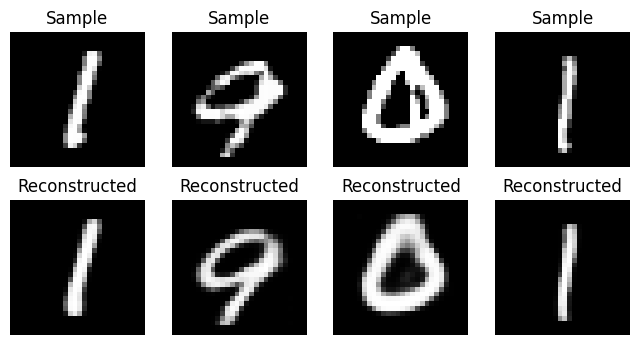

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 184 - Loss: 73.0498


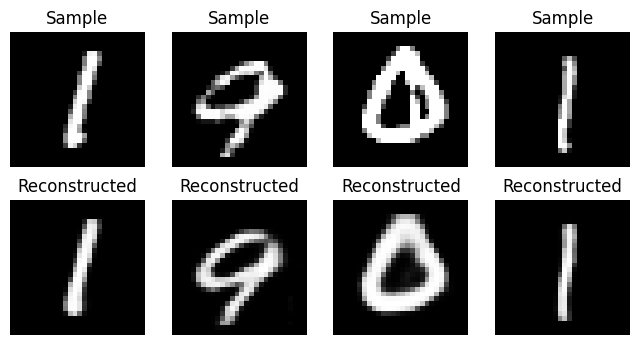

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 185 - Loss: 73.0479


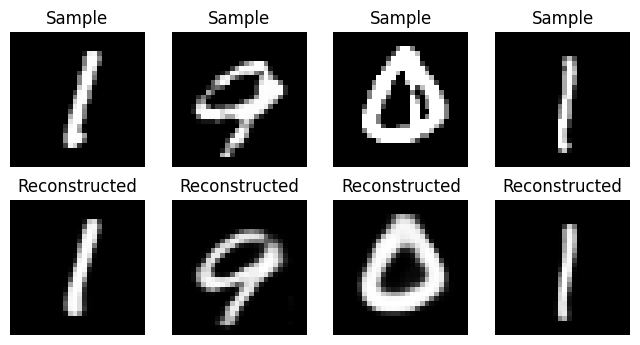

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 186 - Loss: 73.0003


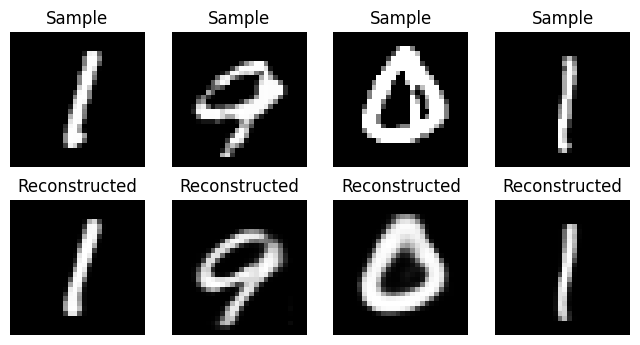

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 187 - Loss: 73.0523


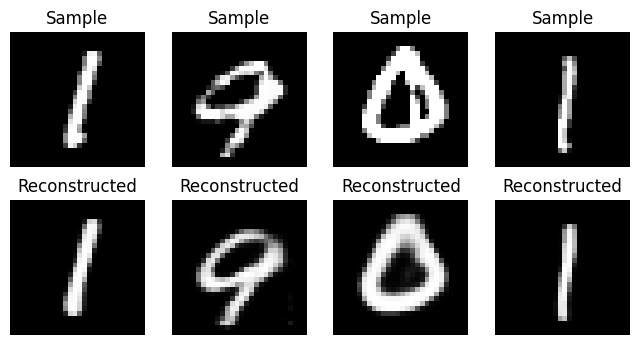

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 188 - Loss: 72.9846


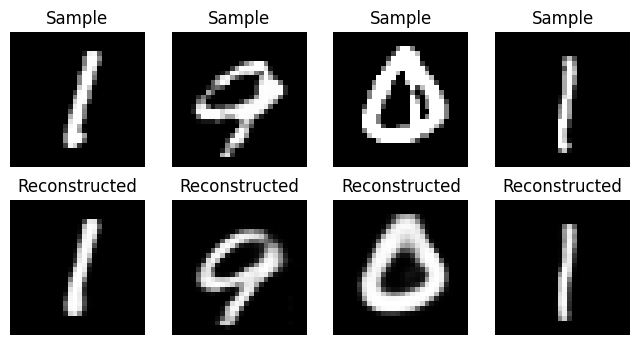

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 189 - Loss: 73.0078


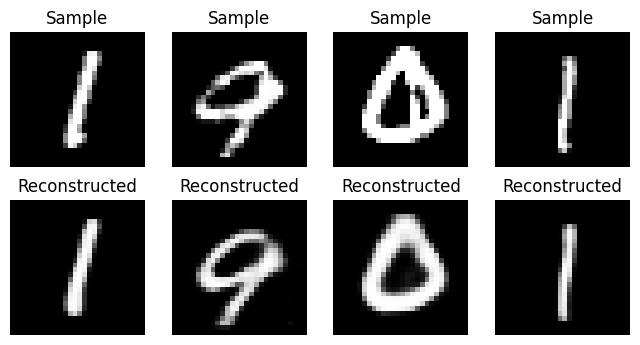

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 190 - Loss: 72.9902


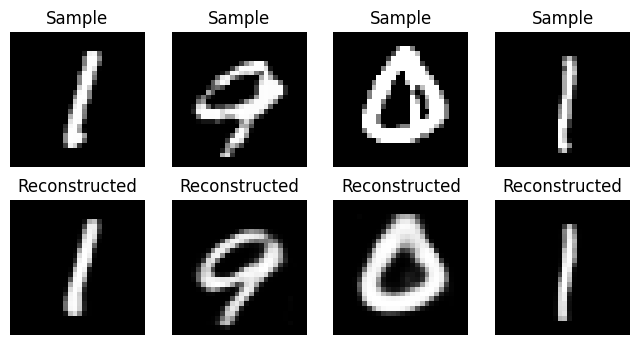

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 191 - Loss: 73.0045


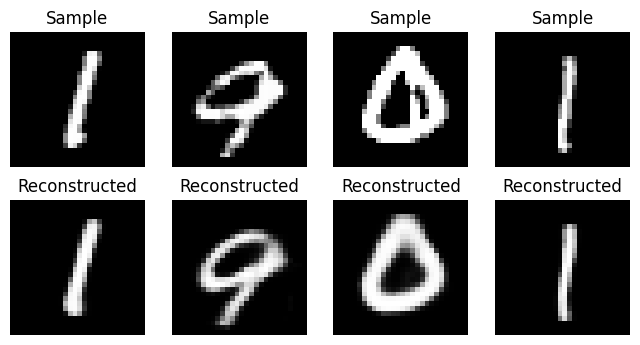

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 192 - Loss: 72.9914


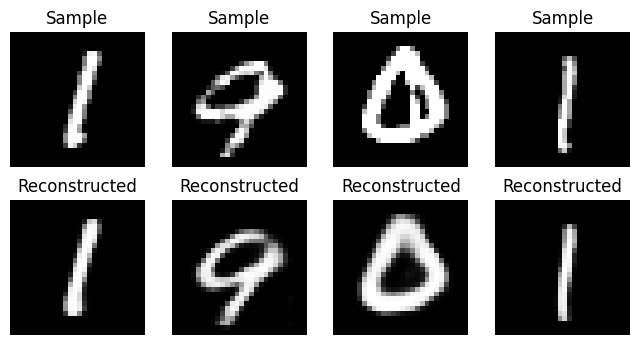

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 193 - Loss: 72.9800


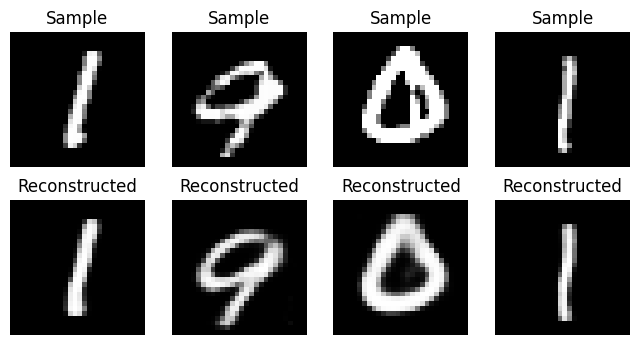

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 194 - Loss: 72.9639


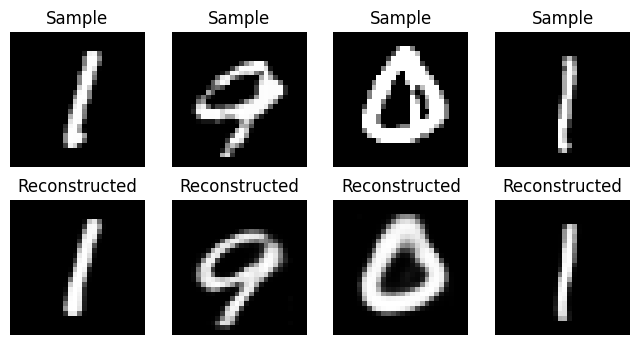

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 195 - Loss: 72.9592


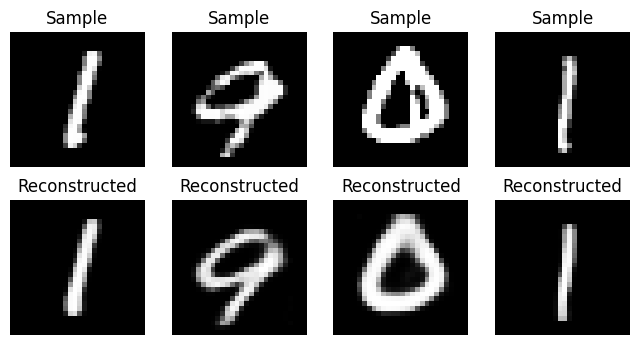

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 196 - Loss: 72.9738


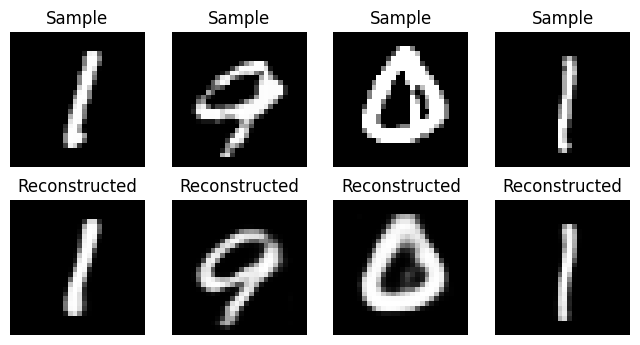

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 197 - Loss: 72.9512


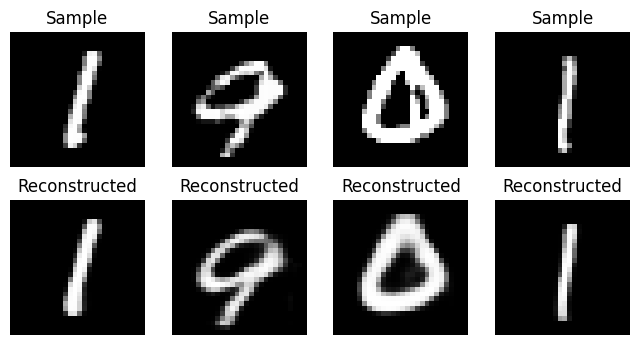

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 198 - Loss: 72.9523


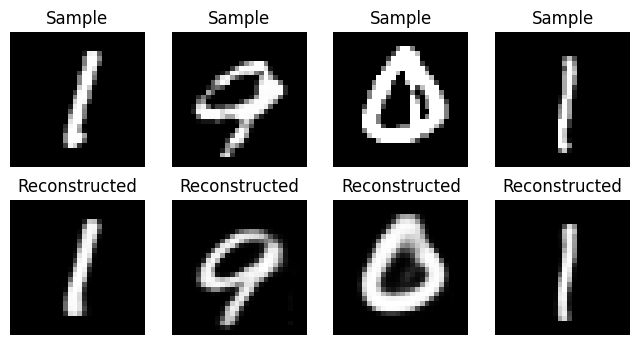

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 199 - Loss: 72.8993


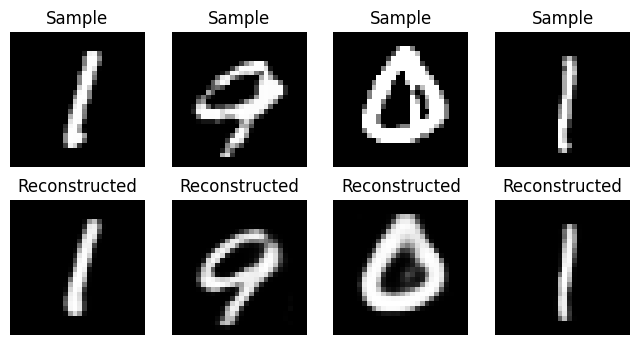

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 200 - Loss: 72.9264


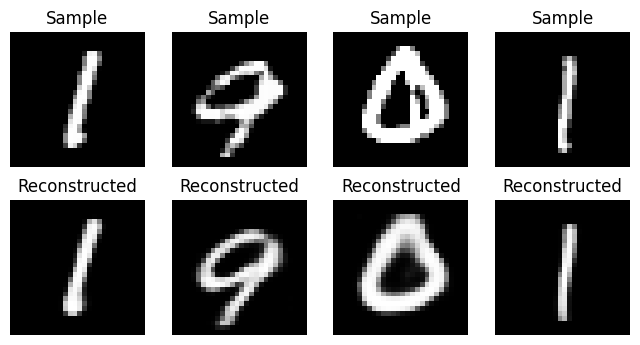

In [ ]:
model = train_vae(train_loader, latent_dim, hidden_dim, input_dim, num_epochs=200)

In [ ]:
torch.save(model.state_dict(), path+'vae.pt')

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [13]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        #######################
        # TODO
        # Define your generator
        #######################

        self.img_shape = img_shape
        self.latent_dim = latent_dim
        nc = img_shape[0]
        ngf = 32

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, ngf*2*4*4),
            nn.BatchNorm1d(ngf*2*4*4),
            nn.ReLU(inplace=True),
        )

        self.network = nn.Sequential(
          nn.Unflatten(1, (ngf*2, 4, 4)),

          nn.ConvTranspose2d(ngf*2, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.LeakyReLU(0.2, inplace=True),

          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.LeakyReLU(0.2, inplace=True),

          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
        )

    def forward(self, z):
        ##############################################
        # TODO
        # generate an image using `z` vector, sampled
        # from a prior distribution.
        # Reshape the result to the shape of original images
        ##############################################
        z = self.fc(z)
        # z = z.view(-1, self.latent_dim, 1, 1)
        img = self.network(z)

        return img

class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()

        ###########################
        # TODO
        # Define your discriminator
        ###########################

        self.img_shape = img_dim
        nc = img_dim[0]
        ndf = 32

        self.network = nn.Sequential(
          nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ndf * 2),
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ndf * 4),
          nn.LeakyReLU(0.2, inplace=True),

          nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
          nn.Sigmoid())

    def forward(self, img):
        ##############################################
        # TODO
        # Predict whether each image in `img` is real or fake.
        ##############################################
        x = self.network(img)
        x = x.view(-1, 1)

        return x

In [14]:
def train_gan(dataloader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizers, generator and discriminator.
    ###############################################
    generator = Generator(latent_dim, img_shape).to(DEVICE) # TODO
    discriminator = Discriminator(img_shape).to(DEVICE) # TODO
    adversarial_loss = nn.BCELoss() # TODO
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate) # TODO
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate) # TODO

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:

                ##########################################################
                # TODO
                # Calculate the loss for the Generator and the Discriminator.
                ##########################################################
                batch_size = imgs.size(0)
                real_imgs = imgs.to(DEVICE)

                # Adversarial ground truths
                valid = torch.ones(batch_size, 1).type_as(real_imgs)
                fake = torch.zeros(batch_size, 1).type_as(real_imgs)

                # Sample noise as generator input
                z = torch.randn(batch_size, latent_dim).type_as(real_imgs).to(DEVICE)

                # -----------------
                #  Train Generator
                # -----------------
                optimizer_G.zero_grad()

                # Generate a batch of images
                generated_imgs = generator(z)

                # Loss measures generator's ability to fool the discriminator
                g_loss = adversarial_loss(discriminator(generated_imgs), valid)

                g_loss.backward()
                optimizer_G.step()

                # ---------------------
                #  Train Discriminator
                # ---------------------
                optimizer_D.zero_grad()

                # Measure discriminator's ability to classify real from generated samples
                real_loss = adversarial_loss(discriminator(real_imgs), valid)
                fake_loss = adversarial_loss(discriminator(generator(z).detach()), fake)

                d_loss = (real_loss + fake_loss) / 2

                d_loss.backward()
                optimizer_D.step()

                # TODO
                # Calculate and fill discriminator and generator losses
                pbar.set_description("[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(epoch, num_epochs, d_loss.item(), g_loss.item()))

        # TODO
        # Plot generated images after each epoch
        generator.eval()
        with torch.no_grad():
          plot_random_smaple(generator, latent_dim, n=4)

    return generator, discriminator

In [15]:
def eval_gan(generator, discriminator, dataloader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4):
    adversarial_loss = nn.BCELoss() # TODO
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate) # TODO
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate) # TODO

    generator.eval()
    discriminator.eval()
    g_val_loss= 0.0
    d_val_loss= 0.0
    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (imgs, _) in pbar:

            batch_size = imgs.size(0)
            real_imgs = imgs.to(DEVICE)

            # Adversarial ground truths
            valid = torch.ones(batch_size, 1).type_as(real_imgs)
            fake = torch.zeros(batch_size, 1).type_as(real_imgs)

            # Sample noise as generator input
            z = torch.randn(batch_size, latent_dim).type_as(real_imgs).to(DEVICE)

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()

            # Generate a batch of images
            generated_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator(generated_imgs), valid)
            g_val_loss += g_loss

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(generator(z).detach()), fake)

            d_loss = (real_loss + fake_loss) / 2
            d_val_loss += g_loss

    print('Validation -', "[D loss: {:.4f}] [G loss: {:.4f}]".format(d_val_loss / len(dataloader.dataset), g_val_loss / len(dataloader.dataset)))


    return

  0%|          | 0/782 [00:00<?, ?it/s]

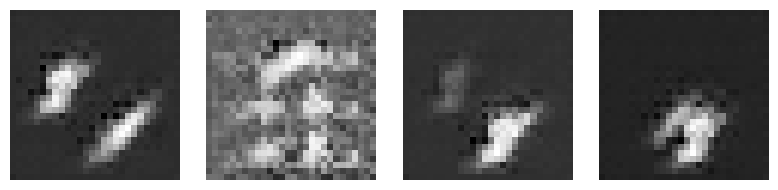

  0%|          | 0/782 [00:00<?, ?it/s]

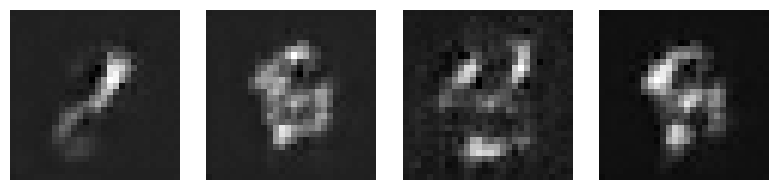

  0%|          | 0/782 [00:00<?, ?it/s]

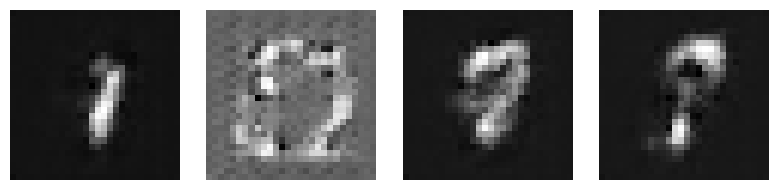

  0%|          | 0/782 [00:00<?, ?it/s]

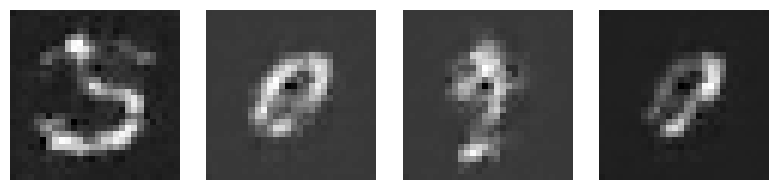

  0%|          | 0/782 [00:00<?, ?it/s]

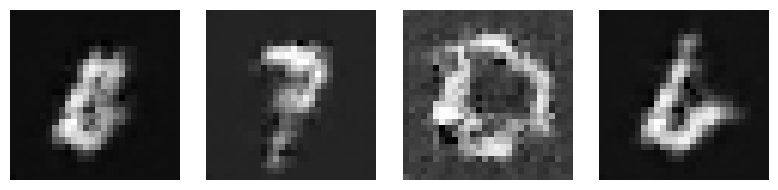

  0%|          | 0/782 [00:00<?, ?it/s]

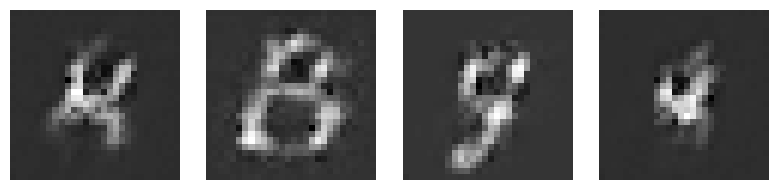

  0%|          | 0/782 [00:00<?, ?it/s]

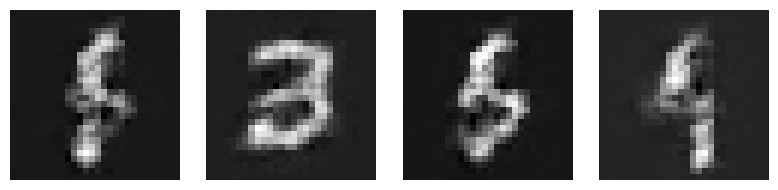

  0%|          | 0/782 [00:00<?, ?it/s]

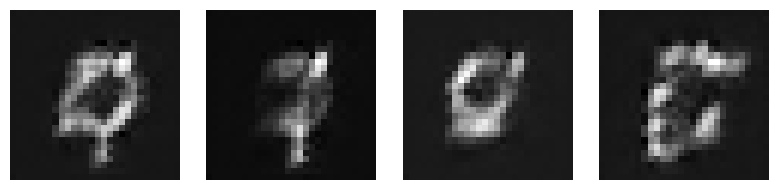

  0%|          | 0/782 [00:00<?, ?it/s]

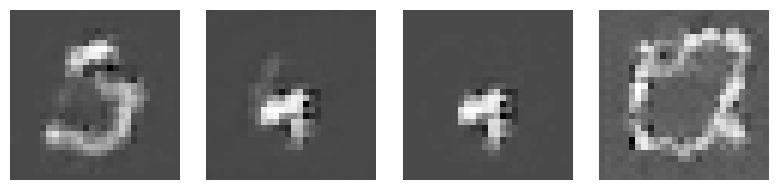

  0%|          | 0/782 [00:00<?, ?it/s]

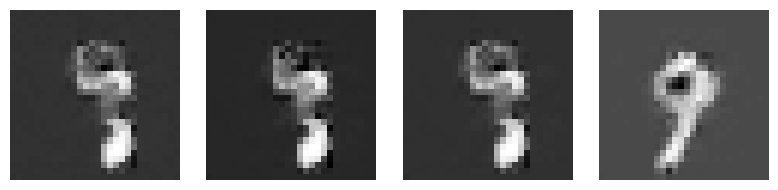

  0%|          | 0/782 [00:00<?, ?it/s]

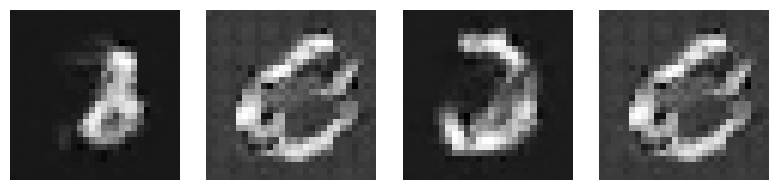

  0%|          | 0/782 [00:00<?, ?it/s]

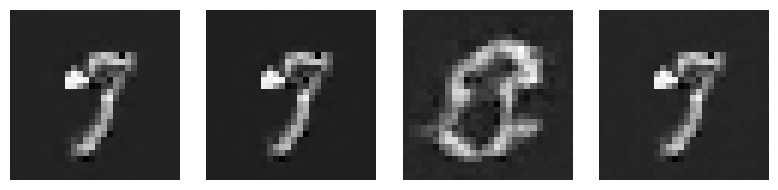

  0%|          | 0/782 [00:00<?, ?it/s]

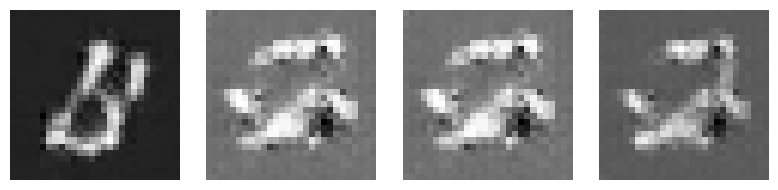

  0%|          | 0/782 [00:00<?, ?it/s]

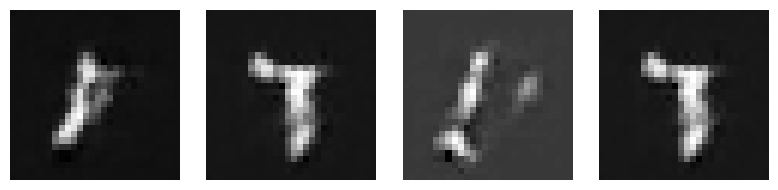

  0%|          | 0/782 [00:00<?, ?it/s]

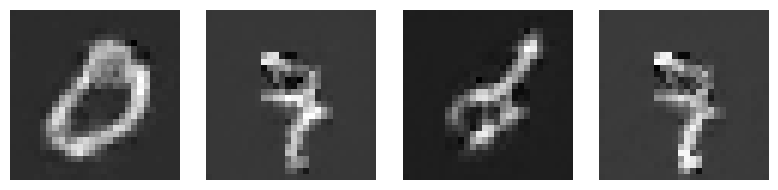

  0%|          | 0/782 [00:00<?, ?it/s]

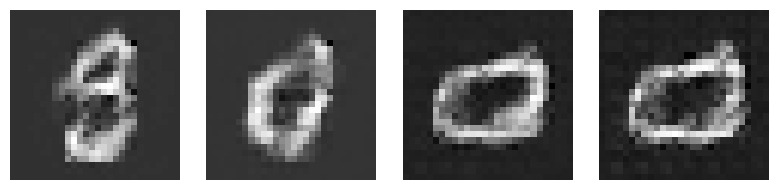

  0%|          | 0/782 [00:00<?, ?it/s]

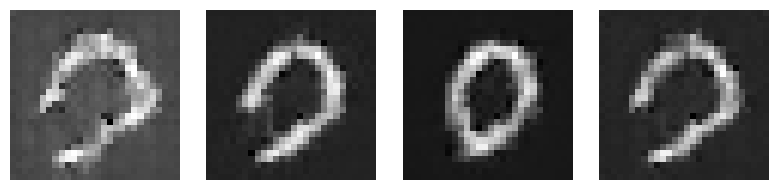

  0%|          | 0/782 [00:00<?, ?it/s]

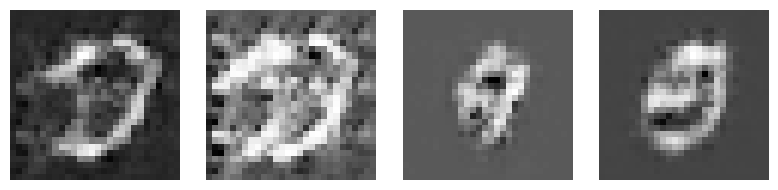

  0%|          | 0/782 [00:00<?, ?it/s]

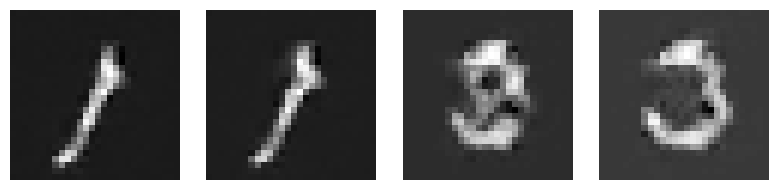

  0%|          | 0/782 [00:00<?, ?it/s]

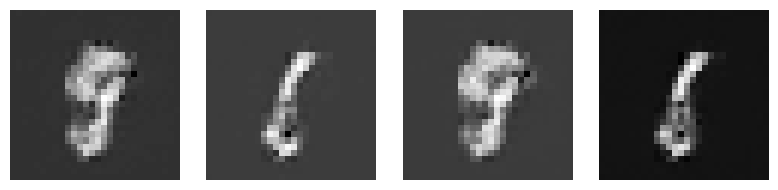

  0%|          | 0/782 [00:00<?, ?it/s]

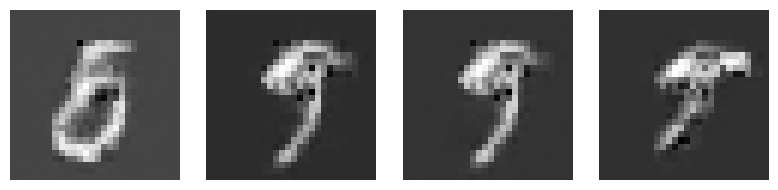

  0%|          | 0/782 [00:00<?, ?it/s]

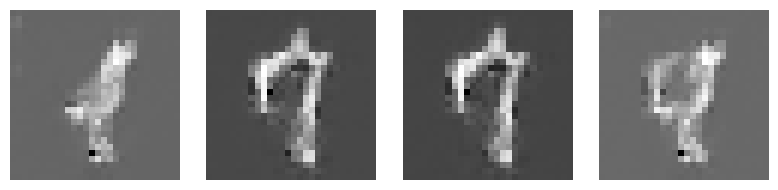

  0%|          | 0/782 [00:00<?, ?it/s]

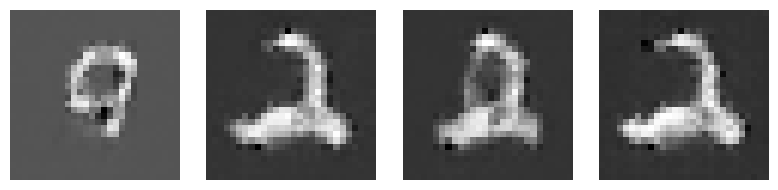

  0%|          | 0/782 [00:00<?, ?it/s]

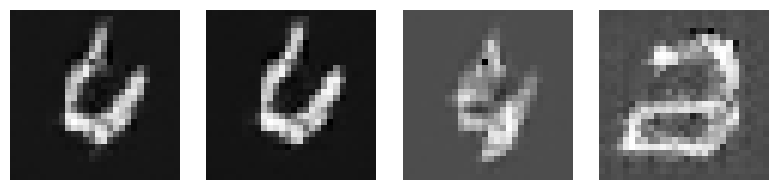

  0%|          | 0/782 [00:00<?, ?it/s]

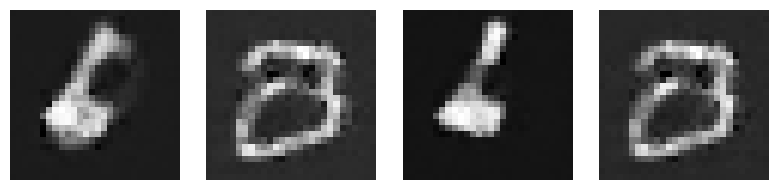

  0%|          | 0/782 [00:00<?, ?it/s]

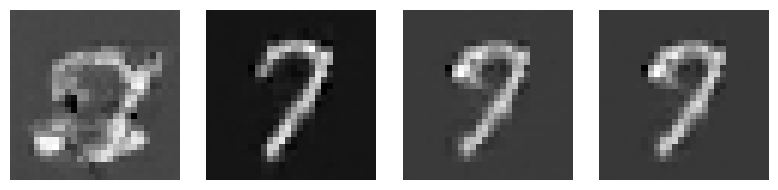

  0%|          | 0/782 [00:00<?, ?it/s]

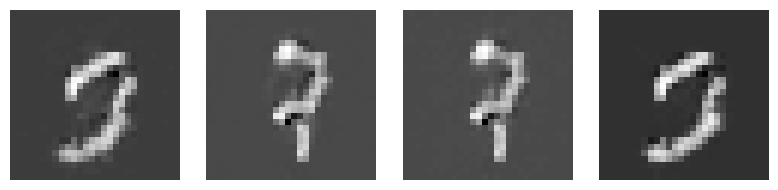

  0%|          | 0/782 [00:00<?, ?it/s]

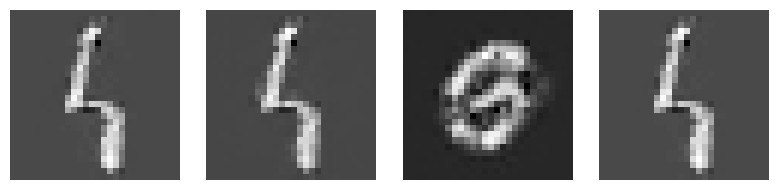

  0%|          | 0/782 [00:00<?, ?it/s]

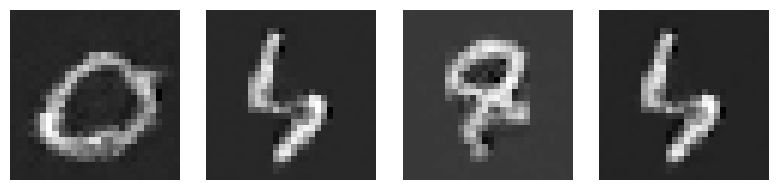

  0%|          | 0/782 [00:00<?, ?it/s]

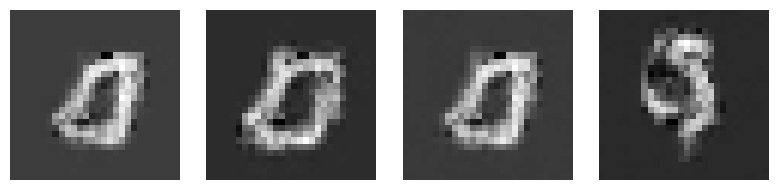

  0%|          | 0/782 [00:00<?, ?it/s]

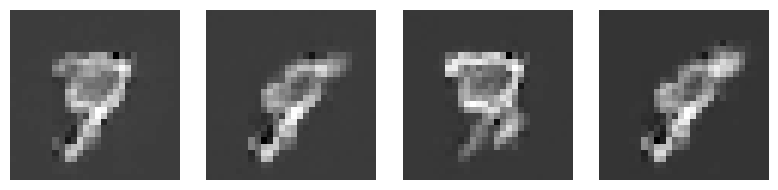

  0%|          | 0/782 [00:00<?, ?it/s]

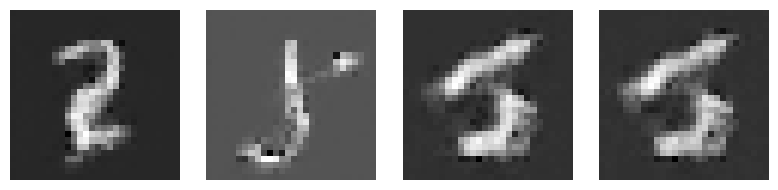

  0%|          | 0/782 [00:00<?, ?it/s]

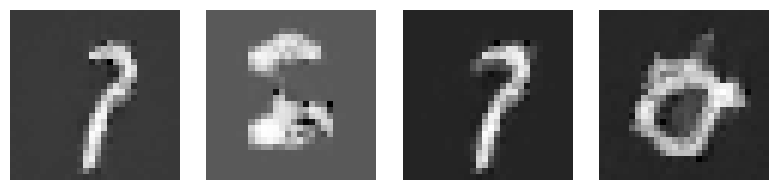

  0%|          | 0/782 [00:00<?, ?it/s]

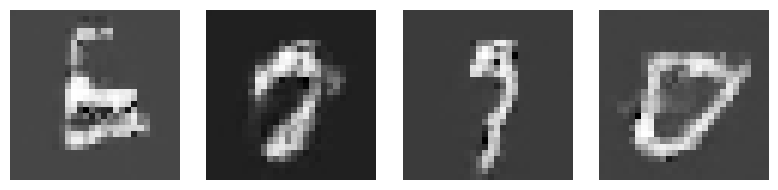

  0%|          | 0/782 [00:00<?, ?it/s]

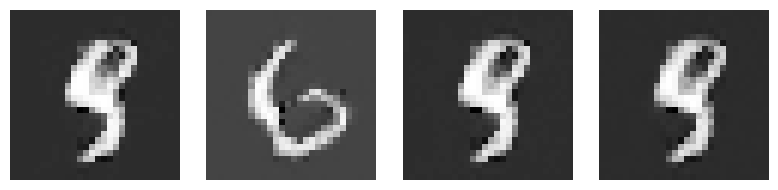

  0%|          | 0/782 [00:00<?, ?it/s]

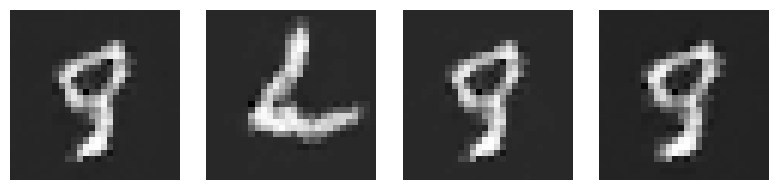

  0%|          | 0/782 [00:00<?, ?it/s]

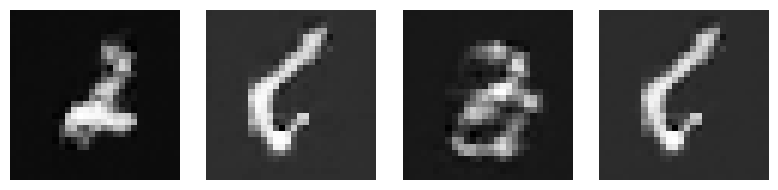

  0%|          | 0/782 [00:00<?, ?it/s]

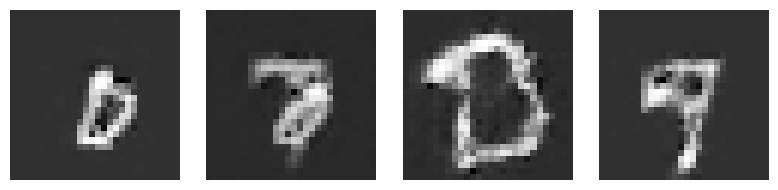

  0%|          | 0/782 [00:00<?, ?it/s]

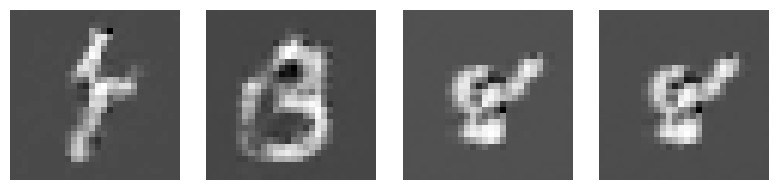

  0%|          | 0/782 [00:00<?, ?it/s]

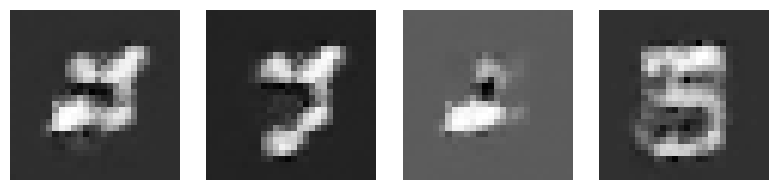

  0%|          | 0/782 [00:00<?, ?it/s]

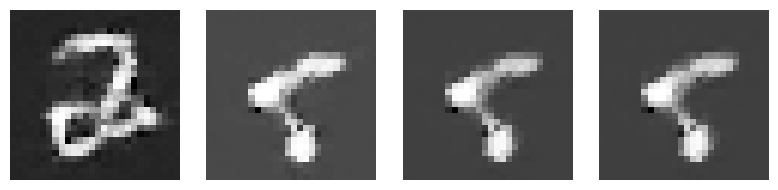

  0%|          | 0/782 [00:00<?, ?it/s]

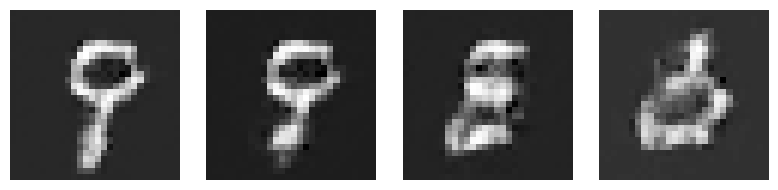

  0%|          | 0/782 [00:00<?, ?it/s]

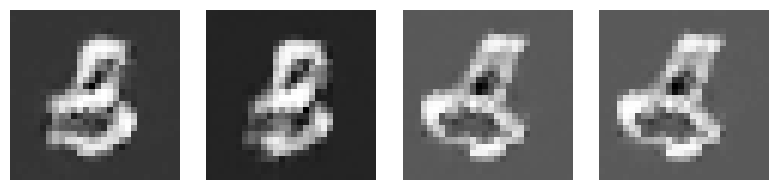

  0%|          | 0/782 [00:00<?, ?it/s]

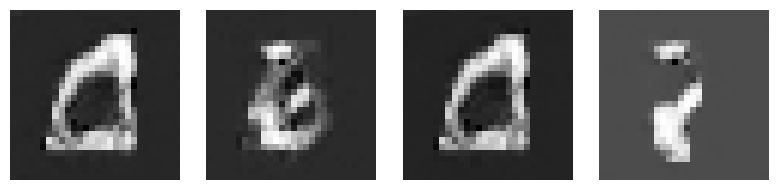

  0%|          | 0/782 [00:00<?, ?it/s]

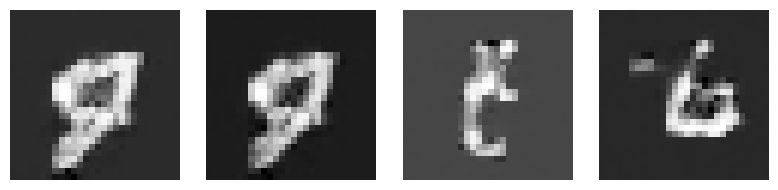

  0%|          | 0/782 [00:00<?, ?it/s]

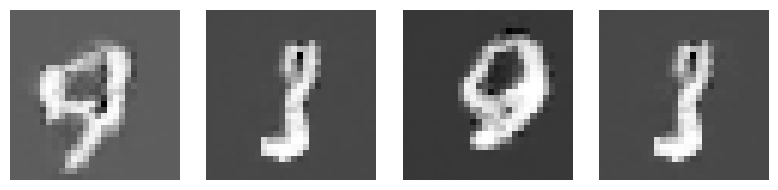

  0%|          | 0/782 [00:00<?, ?it/s]

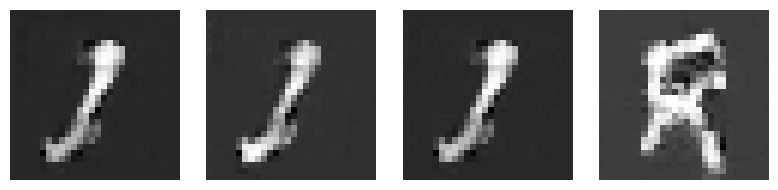

  0%|          | 0/782 [00:00<?, ?it/s]

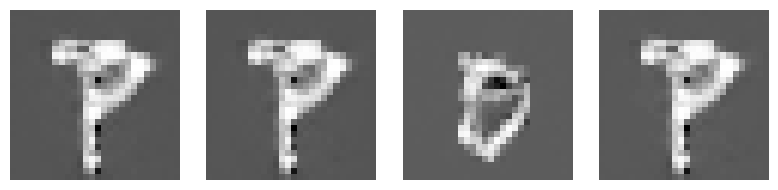

  0%|          | 0/782 [00:00<?, ?it/s]

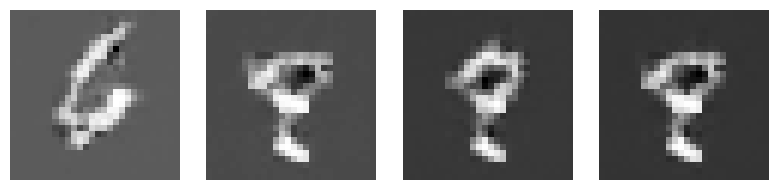

  0%|          | 0/782 [00:00<?, ?it/s]

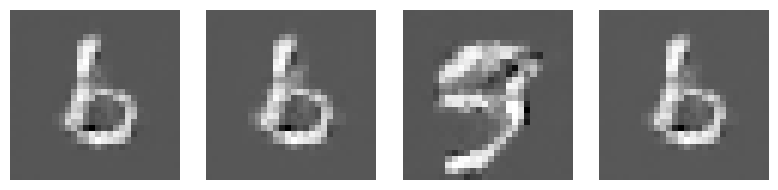

In [21]:
generator, discriminator = train_gan(train_loader, latent_dim=100, num_epochs=50)

In [22]:
torch.save(generator.state_dict(), path+'generator.pt')
torch.save(discriminator.state_dict(), path+'discriminator.pt')

# Compare

Use validation dataset to plot and compare the results of your trained models.

In [ ]:
# TODO
# Comparison of the generated images

## VAE

In [17]:
model = VAE(input_dim=784, hidden_dim=256, latent_dim=10).to(DEVICE)
model.load_state_dict(torch.load(path+'vae.pt'))

<All keys matched successfully>

In [18]:
eval_vae(model, val_loader, latent_dim=10, hidden_dim=256, input_dim=784)

  0%|          | 0/157 [00:00<?, ?it/s]

Validation - Loss: 74.4415


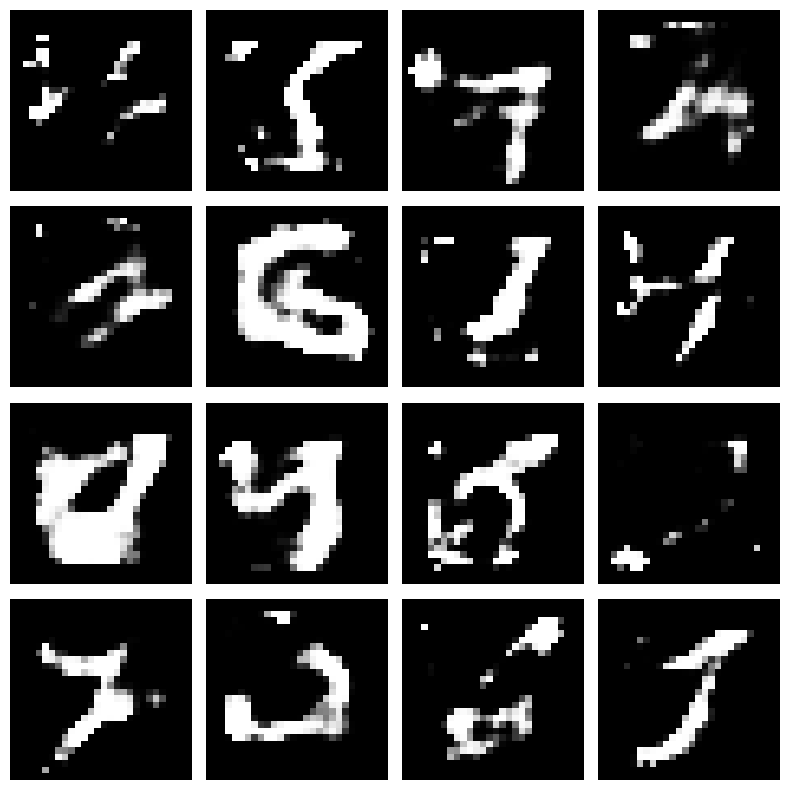

In [20]:
plot_random_smaple(model.decoder, latent_dim=10, n=16)

## GAN

In [23]:
generator = Generator(latent_dim, (1, 28, 28)).to(DEVICE)
generator.load_state_dict(torch.load(path+'generator.pt'))

discriminator = Discriminator((1, 28, 28)).to(DEVICE)
discriminator.load_state_dict(torch.load(path+'discriminator.pt'))

In [24]:
eval_gan(generator, discriminator, val_loader, latent_dim=100)

  0%|          | 0/157 [00:00<?, ?it/s]

Validation - [D loss: 0.0492] [G loss: 0.0492]


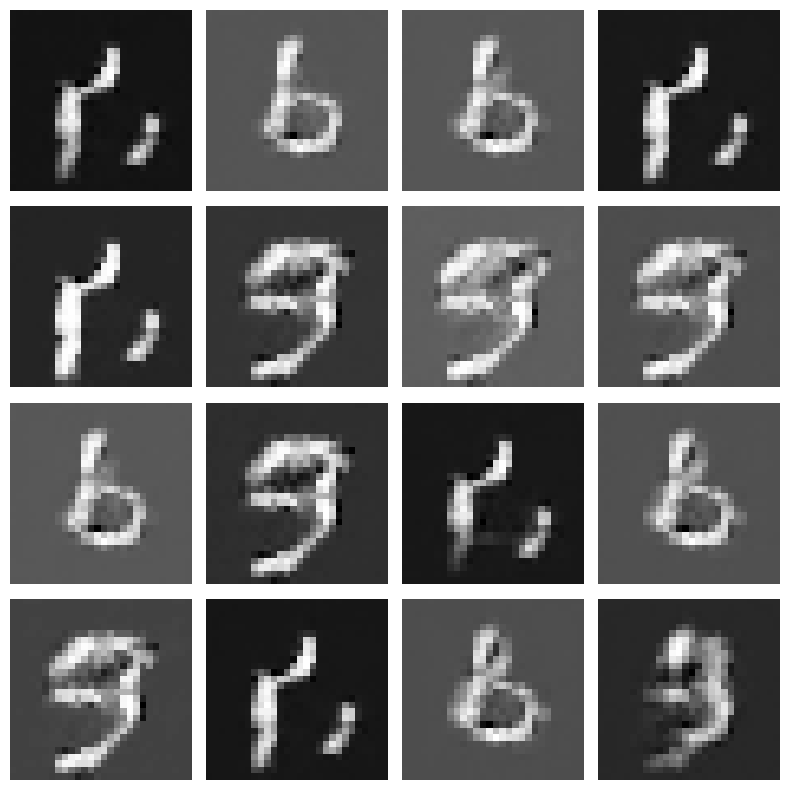

In [25]:
plot_random_smaple(generator, latent_dim=100, n=16)

## Discrimintor

In [ ]:
adversarial_loss = nn.BCELoss()

# Adversarial ground truths
valid = torch.ones(1, 1).to(DEVICE)

# Sample noise as generator input
z = torch.randn(1, 10).to(DEVICE)

# Generate a batch of images
generated_imgs = model.decoder(z).view(1, 1, 28, 28)

# Loss measures generator's ability to fool the discriminator
g_loss = adversarial_loss(discriminator(generated_imgs), valid)
g_loss

In [ ]:
adversarial_loss = nn.BCELoss()

# Adversarial ground truths
valid = torch.ones(1, 1).to(DEVICE)

# Sample noise as generator input
z = torch.randn(1, 100).to(DEVICE)

# Generate a batch of images
generated_imgs = generator(z)

# Loss measures generator's ability to fool the discriminator
g_loss = adversarial_loss(discriminator(generated_imgs), valid)
g_loss

# References
- [VAE-Github](https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb)
- [GAN-Github](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py)
- [DCGAN](https://github.com/AKASHKADEL/dcgan-mnist/blob/master/networks.py)